### 


In [1]:
import pandas as pd
import numpy as np
from eliana.datasets import ParlogsObservations

In [2]:
INSTRUMENT='MATISSE'
RANGE='6m'

In [3]:
logs = ParlogsObservations(period=RANGE, source="Instrument", system=INSTRUMENT)

In [4]:
df_meta = logs.meta
df_traces = logs.traces()
TPL_IDs = logs.meta['TPL_ID'].value_counts()
print(TPL_IDs)

TPL_ID
MATISSE_hyb_obs                      1612
MATISSE_img_acq                      1467
MATISSE_gen_tec_opd                  1059
MATISSE_gen_cal_bias                  724
MATISSE_gen_cal_imbasic               399
MATISSE_gen_cal_transfunc             241
MATISSE_gen_tec_standby               199
MATISSE_gen_tec_ali                   185
MATISSE_gen_tec_check_fringes         183
MATISSE_img_acq_ft                    174
MATISSE_gen_tec_simple_rec            130
MATISSE_gen_cal_kappa                  56
MATISSE_gen_cal_shift                  50
CALOB_gen_tec_log                      37
errseverity                            33
MATISSE_gen_tec_setup_coude_train      27
MATISSE_gen_cal_det_aq                 22
MATISSE_gen_cal_det_h2                 21
MATISSE_gen_tec_piezos                 13
MATISSE_gen_tec_setup_lab               7
MATISSE_gen_cal_imext_aq                5
MATISSE_gen_cal_imrem_aq                3
MATISSE_gen_cal_imrem                   2
MATISSE_gen_cal_imext_h2   

In [5]:
TPL_IDs_Error=df_meta[df_meta['ERROR'] == True]
TPL_IDs_Error['TPL_ID'].value_counts()

TPL_ID
MATISSE_gen_tec_ali              67
MATISSE_hyb_obs                  43
MATISSE_img_acq                  39
errseverity                      27
MATISSE_img_acq_ft               23
MATISSE_gen_tec_opd              20
MATISSE_gen_cal_det_aq           15
MATISSE_gen_tec_check_fringes    10
MATISSE_gen_cal_bias              9
MATISSE_gen_cal_imbasic           6
MATISSE_gen_cal_det_h2            3
MATISSE_gen_cal_shift             3
MATISSE_gen_cal_kappa             2
MATISSE_gen_tec_piezos            2
MATISSE_gen_cal_transfunc         1
Name: count, dtype: int64

In [6]:
TPL = set(TPL_IDs.index) & set(TPL_IDs_Error['TPL_ID'])
print(TPL)

{'MATISSE_img_acq_ft', 'MATISSE_gen_tec_piezos', 'MATISSE_gen_cal_bias', 'MATISSE_img_acq', 'MATISSE_gen_tec_opd', 'MATISSE_gen_cal_det_aq', 'MATISSE_gen_cal_kappa', 'MATISSE_gen_cal_transfunc', 'errseverity', 'MATISSE_gen_cal_det_h2', 'MATISSE_gen_cal_shift', 'MATISSE_gen_cal_imbasic', 'MATISSE_gen_tec_ali', 'MATISSE_hyb_obs', 'MATISSE_gen_tec_check_fringes'}


In [7]:
df_meta['ERROR'].value_counts()

ERROR
False    6383
True      270
Name: count, dtype: int64

In [8]:
def extract_params(df_original):
    # df is a copy fo df_original
    df = df_original.copy()
    
    # Filter rows where @timestamp are the first 3 seconds of the whole df
    df = df[df['@timestamp'] < df['@timestamp'].min() + pd.Timedelta(seconds=3)]
    
    # Filter where column logtext has the form (any string)' = '(anystring), and exactly one = sign
    df = df[df['logtext'].str.contains(r"^.* = .*$")] 
    
    # Create column "param" with left part of ' = ', and column "value" with right part of ' = '
    df['param'] = df['logtext'].str.split(' = ').str[0]
    df['value'] = df['logtext'].str.split(' = ').str[1]
    
    # Restrict to columns param and value
    df = df[['param', 'value']]
    
    # Replace spaces by dot in param
    df['param'] = df['param'].str.replace(" ", ".")

    # Remove extra ' enclosing value
    df['value'] = df['value'].str.replace("'", "")
    
    # Create a column numval with the numeric value of value, if possible, otherwise NaN
    df['numval'] = pd.to_numeric(df['value'], errors='coerce')
    
    # Create column strval if numval is NaN, otherwise empty string
    df['strval'] = df['value'].where(df['numval'].isna(), "")
    
    # Remove column value-
    df = df.drop(columns=['value']) 

    # Set param as the index
    df = df.set_index('param')

    df = df.sort_index()  
    return df


### Separar los dataframes en dos carpetas, una para los que no tienen errores y otra para los que tienen errores

In [9]:
df_meta_Error= df_meta[df_meta['ERROR'] == True]

In [10]:
df_meta_2 = df_meta[~df_meta['START'].isin(df_meta_Error['START'])]

### Funciones:
* Funcion para extraer los parametros
* Funcion para graficar los parametros

In [11]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['font.size'] = 10

def graficos_dispersion_por_columna(df_sin_error, df_con_error):
    columnas_parametros = [col for col in df_sin_error.columns if col != 'param']

    print(f"Creando gráficos para {len(columnas_parametros)} parámetros...")
    print(f"Observaciones sin error: {len(df_sin_error)}")
    print(f"Observaciones con error: {len(df_con_error)}")

    n_params = len(columnas_parametros)
    cols = 3
    rows = (n_params + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    fig.suptitle('Dispersión de Parámetros\nRojo: Con Error | Azul: Sin Error', 
                 fontsize=18, fontweight='bold', y=0.995)

    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    axes_flat = axes.flatten()

    for i, param in enumerate(columnas_parametros):
        ax = axes_flat[i]
        x_sin_error = range(len(df_sin_error))
        x_con_error = range(len(df_con_error))
        y_sin_error = df_sin_error[param]
        y_con_error = df_con_error[param]

        ax.scatter(x_sin_error, y_sin_error, c='blue', alpha=0.6, s=20,
                   label=f'Sin error (n={len(df_sin_error)})', edgecolors='darkred', linewidth=0.3)

        ax.scatter(x_con_error, y_con_error, c='red', alpha=0.6, s=20,
                   label=f'Con error (n={len(df_con_error)})', edgecolors='darkblue', linewidth=0.3)

        ax.set_title(param, fontweight='bold', fontsize=11)
        ax.set_xlabel('Índice de Observación')
        ax.set_ylabel('Valor del Parámetro')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

        # Resaltar si todos los valores son constantes
        if y_sin_error.std() == 0 and y_con_error.std() == 0:
            ax.text(0.5, 0.5, 'VALORES\nCONSTANTES', transform=ax.transAxes,
                    ha='center', va='center', fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))

    for i in range(len(columnas_parametros), len(axes_flat)):
        axes_flat[i].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [13]:
import pandas as pd

def extract_trace_parameters(df_meta, df_traces, extract_params, tpl_id='MATISSE_img_acq'):
    """
    Extrae parámetros numéricos de trazas de un DataFrame de trazas filtrado por un TPL_ID específico.

    Args:
        df_meta (pd.DataFrame): DataFrame que contiene información de metadatos con columna 'TPL_ID'.
        df_traces (pd.DataFrame): DataFrame que contiene las trazas, con columna 'trace_id'.
        extract_params (function): Función que toma un DataFrame de una traza y devuelve un DataFrame con parámetros.
        tpl_id (str): Valor de TPL_ID por el cual se desea filtrar (por defecto 'MATISSE_img_acq').

    Returns:
        pd.DataFrame: DataFrame con los parámetros numéricos extraídos por cada trace_id.
    """
    # Indices de los trace_id que coinciden con el TPL_ID especificado
    tpl_indices = df_meta[df_meta['TPL_ID'] == tpl_id].index

    # Filtrar df_traces usando los trace_id anteriores
    df_filtered = df_traces[df_traces['trace_id'].isin(tpl_indices)]

    # Extraer parámetros
    params_dict = {}
    for trace_id in df_filtered['trace_id'].unique():
        df_trace = df_filtered[df_filtered['trace_id'] == trace_id]
        params = extract_params(df_trace)

        # Eliminar duplicados de índice
        params = params[~params.index.duplicated(keep='first')]
        params_dict[trace_id] = params

    params_df = pd.concat(
        {trace_id: df['numval'] for trace_id, df in params_dict.items()},
        axis=1).T

    params_df = params_df.sort_index(axis=1)

    params_df = params_df.dropna(how='all')        
    params_df = params_df.dropna(axis=1, how='all') 

    return params_df


In [14]:
params_df = extract_trace_parameters(df_meta, df_traces, extract_params, tpl_id='MATISSE_hyb_obs')


In [15]:
params_df.describe()

param  COU.AG.ALPHA  COU.AG.DELTA  COU.AG.EPOCH  COU.AG.EQUINOX  COU.AG.PMA  \
count          14.0          14.0          14.0            14.0        14.0   
mean            0.0           0.0        2000.0          2000.0         0.0   
std             0.0           0.0           0.0             0.0         0.0   
min             0.0           0.0        2000.0          2000.0         0.0   
25%             0.0           0.0        2000.0          2000.0         0.0   
50%             0.0           0.0        2000.0          2000.0         0.0   
75%             0.0           0.0        2000.0          2000.0         0.0   
max             0.0           0.0        2000.0          2000.0         0.0   

param  COU.AG.PMD  COU.GS.MAG  DEL.REF.NAME  DEL.REF.OPL  DET1.APOTYPE.VAL  \
count        14.0   14.000000          12.0         14.0            1612.0   
mean          0.0    4.007143           1.0         30.0               0.0   
std           0.0    2.423114           0.0          0.0               0.0   
min           0.0    0.000000           1.0         30.0               0.0   
25%           0.0    3.000000           1.0         30.0               0.0   
50%           0.0    4.800000           1.0         30.0               0.0   
75%           0.0    6.000000           1.0         30.0               0.0   
max           0.0    6.500000           1.0         30.0               0.0   

param  ...  TEL.GS1.ALPHA  TEL.GS1.DELTA  TEL.GS1.MAG  TEL.TARG.ADDVELALPHA  \
count  ...           14.0           14.0         14.0                  14.0   
mean   ...            0.0            0.0         12.0                   0.0   
std    ...            0.0            0.0          0.0                   0.0   
min    ...            0.0            0.0         12.0                   0.0   
25%    ...            0.0            0.0         12.0                   0.0   
50%    ...            0.0            0.0         12.0                   0.0   
75%    ...            0.0            0.0         12.0                   0.0   
max    ...            0.0            0.0         12.0                   0.0   

param  TEL.TARG.ADDVELDELTA  TEL.TARG.ALPHA  TEL.TARG.DELTA  TEL.TARG.EQUINOX  \
count                  14.0       14.000000       14.000000              14.0   
mean                    0.0   110064.188571  -142529.225714            2000.0   
std                     0.0    26747.287665   249227.511657               0.0   
min                     0.0    21920.790000  -602404.129000            2000.0   
25%                     0.0   110149.674000  -343959.850000            2000.0   
50%                     0.0   115485.598000   -22904.501000            2000.0   
75%                     0.0   124093.959750    19340.203000            2000.0   
max                     0.0   130210.597000   105732.941000            2000.0   

param  TEL.TARG.PMA  TEL.TARG.PMD  
count     14.000000     14.000000  
mean      17.832726     -0.025145  
std       66.822380      0.069225  
min       -0.278800     -0.237000  
25%       -0.014807     -0.035560  
50%        0.000690     -0.009060  
75%        0.009760     -0.002125  
max      250.000000      0.091670  

[8 rows x 81 columns]

### Extracción de parámetros numéricos de las trazas

In [16]:
import os

output_dir = "params_por_tpl"
os.makedirs(output_dir, exist_ok=True)

tpl_params_dict = {}

for tpl_id in TPL:
    print(f"Procesando TPL_ID: {tpl_id}")
    
    # Extraer parámetros
    params_df = extract_trace_parameters(df_meta_2, df_traces, extract_params, tpl_id=tpl_id)
    
    # Filtrar columnas con más del 50% de NaN
    threshold = 0.5
    params_df = params_df.loc[:, params_df.isna().mean() < threshold]
    # Filtrar filas con >50% NaN
    params_df = params_df.loc[params_df.isna().mean(axis=1) < threshold, :]

    # Solo guardar si hay datos válidos
    if not params_df.empty:
        tpl_params_dict[tpl_id] = params_df
        safe_tpl_id = str(tpl_id).replace("/", "_").replace(" ", "_")
        filename = os.path.join(output_dir, f"params_{safe_tpl_id}.csv")

        params_df.to_csv(filename)
        print(f"Guardado: {filename}")
    else:
        print(f"No se guardó {tpl_id} porque el DataFrame está vacío después del filtrado.")


Procesando TPL_ID: MATISSE_img_acq_ft
Guardado: params_por_tpl\params_MATISSE_img_acq_ft.csv
Procesando TPL_ID: MATISSE_gen_tec_piezos
Guardado: params_por_tpl\params_MATISSE_gen_tec_piezos.csv
Procesando TPL_ID: MATISSE_gen_cal_bias
Guardado: params_por_tpl\params_MATISSE_gen_cal_bias.csv
Procesando TPL_ID: MATISSE_img_acq
Guardado: params_por_tpl\params_MATISSE_img_acq.csv
Procesando TPL_ID: MATISSE_gen_tec_opd
Guardado: params_por_tpl\params_MATISSE_gen_tec_opd.csv
Procesando TPL_ID: MATISSE_gen_cal_det_aq
Guardado: params_por_tpl\params_MATISSE_gen_cal_det_aq.csv
Procesando TPL_ID: MATISSE_gen_cal_kappa
Guardado: params_por_tpl\params_MATISSE_gen_cal_kappa.csv
Procesando TPL_ID: MATISSE_gen_cal_transfunc
Guardado: params_por_tpl\params_MATISSE_gen_cal_transfunc.csv
Procesando TPL_ID: errseverity
Guardado: params_por_tpl\params_errseverity.csv
Procesando TPL_ID: MATISSE_gen_cal_det_h2
Guardado: params_por_tpl\params_MATISSE_gen_cal_det_h2.csv
Procesando TPL_ID: MATISSE_gen_cal_shift

In [17]:
import os

output_dir = "params_por_tpl_Error"

os.makedirs(output_dir, exist_ok=True)

tpl_params_dict = {}

for tpl_id in TPL:
    print(f"Procesando TPL_ID: {tpl_id}")
    
    # Extraer parámetros
    params_df = extract_trace_parameters(df_meta_Error, df_traces, extract_params, tpl_id=tpl_id)
    
    # Filtrar columnas con más del 50% de NaN
    threshold = 0.5
    params_df = params_df.loc[:, params_df.isna().mean() < threshold]
    # Filtrar filas con >50% NaN
    params_df = params_df.loc[params_df.isna().mean(axis=1) < threshold, :]

    # Solo guardar si hay datos válidos
    if not params_df.empty:
        tpl_params_dict[tpl_id] = params_df
        
        # Nombre seguro para archivo
        safe_tpl_id = str(tpl_id).replace("/", "_").replace(" ", "_")
        filename = os.path.join(output_dir, f"params_{safe_tpl_id}.csv")

        params_df.to_csv(filename)
        print(f"Guardado: {filename}")
    else:
        print(f"No se guardó {tpl_id} porque el DataFrame está vacío después del filtrado.")


Procesando TPL_ID: MATISSE_img_acq_ft
Guardado: params_por_tpl_Error\params_MATISSE_img_acq_ft.csv
Procesando TPL_ID: MATISSE_gen_tec_piezos
Guardado: params_por_tpl_Error\params_MATISSE_gen_tec_piezos.csv
Procesando TPL_ID: MATISSE_gen_cal_bias
Guardado: params_por_tpl_Error\params_MATISSE_gen_cal_bias.csv
Procesando TPL_ID: MATISSE_img_acq
Guardado: params_por_tpl_Error\params_MATISSE_img_acq.csv
Procesando TPL_ID: MATISSE_gen_tec_opd
Guardado: params_por_tpl_Error\params_MATISSE_gen_tec_opd.csv
Procesando TPL_ID: MATISSE_gen_cal_det_aq
Guardado: params_por_tpl_Error\params_MATISSE_gen_cal_det_aq.csv
Procesando TPL_ID: MATISSE_gen_cal_kappa
Guardado: params_por_tpl_Error\params_MATISSE_gen_cal_kappa.csv
Procesando TPL_ID: MATISSE_gen_cal_transfunc
Guardado: params_por_tpl_Error\params_MATISSE_gen_cal_transfunc.csv
Procesando TPL_ID: errseverity
Guardado: params_por_tpl_Error\params_errseverity.csv
Procesando TPL_ID: MATISSE_gen_cal_det_h2
Guardado: params_por_tpl_Error\params_MATISSE

In [18]:
import os
import pandas as pd


input_dirs = ["params_por_tpl", "params_por_tpl_Error"]

for input_dir in input_dirs:
    print(f"\n Leyendo archivos desde: {input_dir}")

    for filename in os.listdir(input_dir):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_dir, filename)
            df = pd.read_csv(file_path, index_col=0)

            print("\n" + "="*100)
            print(f" Descripción de: {filename}")
            print("="*100)

            desc = df.select_dtypes(include='number').describe().T.round(2) 
            print(desc)




 Leyendo archivos desde: params_por_tpl

 Descripción de: params_errseverity.csv
                      count    mean   std     min     25%     50%     75%  \
DET1.APOTYPE.VAL        4.0    0.00  0.00    0.00    0.00    0.00    0.00   
DET1.APOX.VAL           4.0  512.00  0.00  512.00  512.00  512.00  512.00   
DET1.APOY.VAL           4.0  512.00  0.00  512.00  512.00  512.00  512.00   
DET1.DIT                4.0    0.32  0.36    0.02    0.02    0.26    0.56   
DET1.INTERFX.VAL        4.0  512.00  0.00  512.00  512.00  512.00  512.00   
DET1.INTERFY.VAL        4.0  512.00  0.00  512.00  512.00  512.00  512.00   
DET1.NCOHERENT.VAL      4.0    1.00  0.00    1.00    1.00    1.00    1.00   
DET1.NDIT               4.0   40.00  0.00   40.00   40.00   40.00   40.00   
DET1.NINCOHERENT.VAL    4.0    1.00  0.00    1.00    1.00    1.00    1.00   
DET1.SNRLIMIT.VAL       4.0    5.00  0.00    5.00    5.00    5.00    5.00   
DET1.WLMAXCUT.VAL       4.0    4.80  0.00    4.80    4.80    4.80    4.


Comparando params_errseverity.csv
Creando gráficos para 27 parámetros...
Observaciones sin error: 4
Observaciones con error: 26


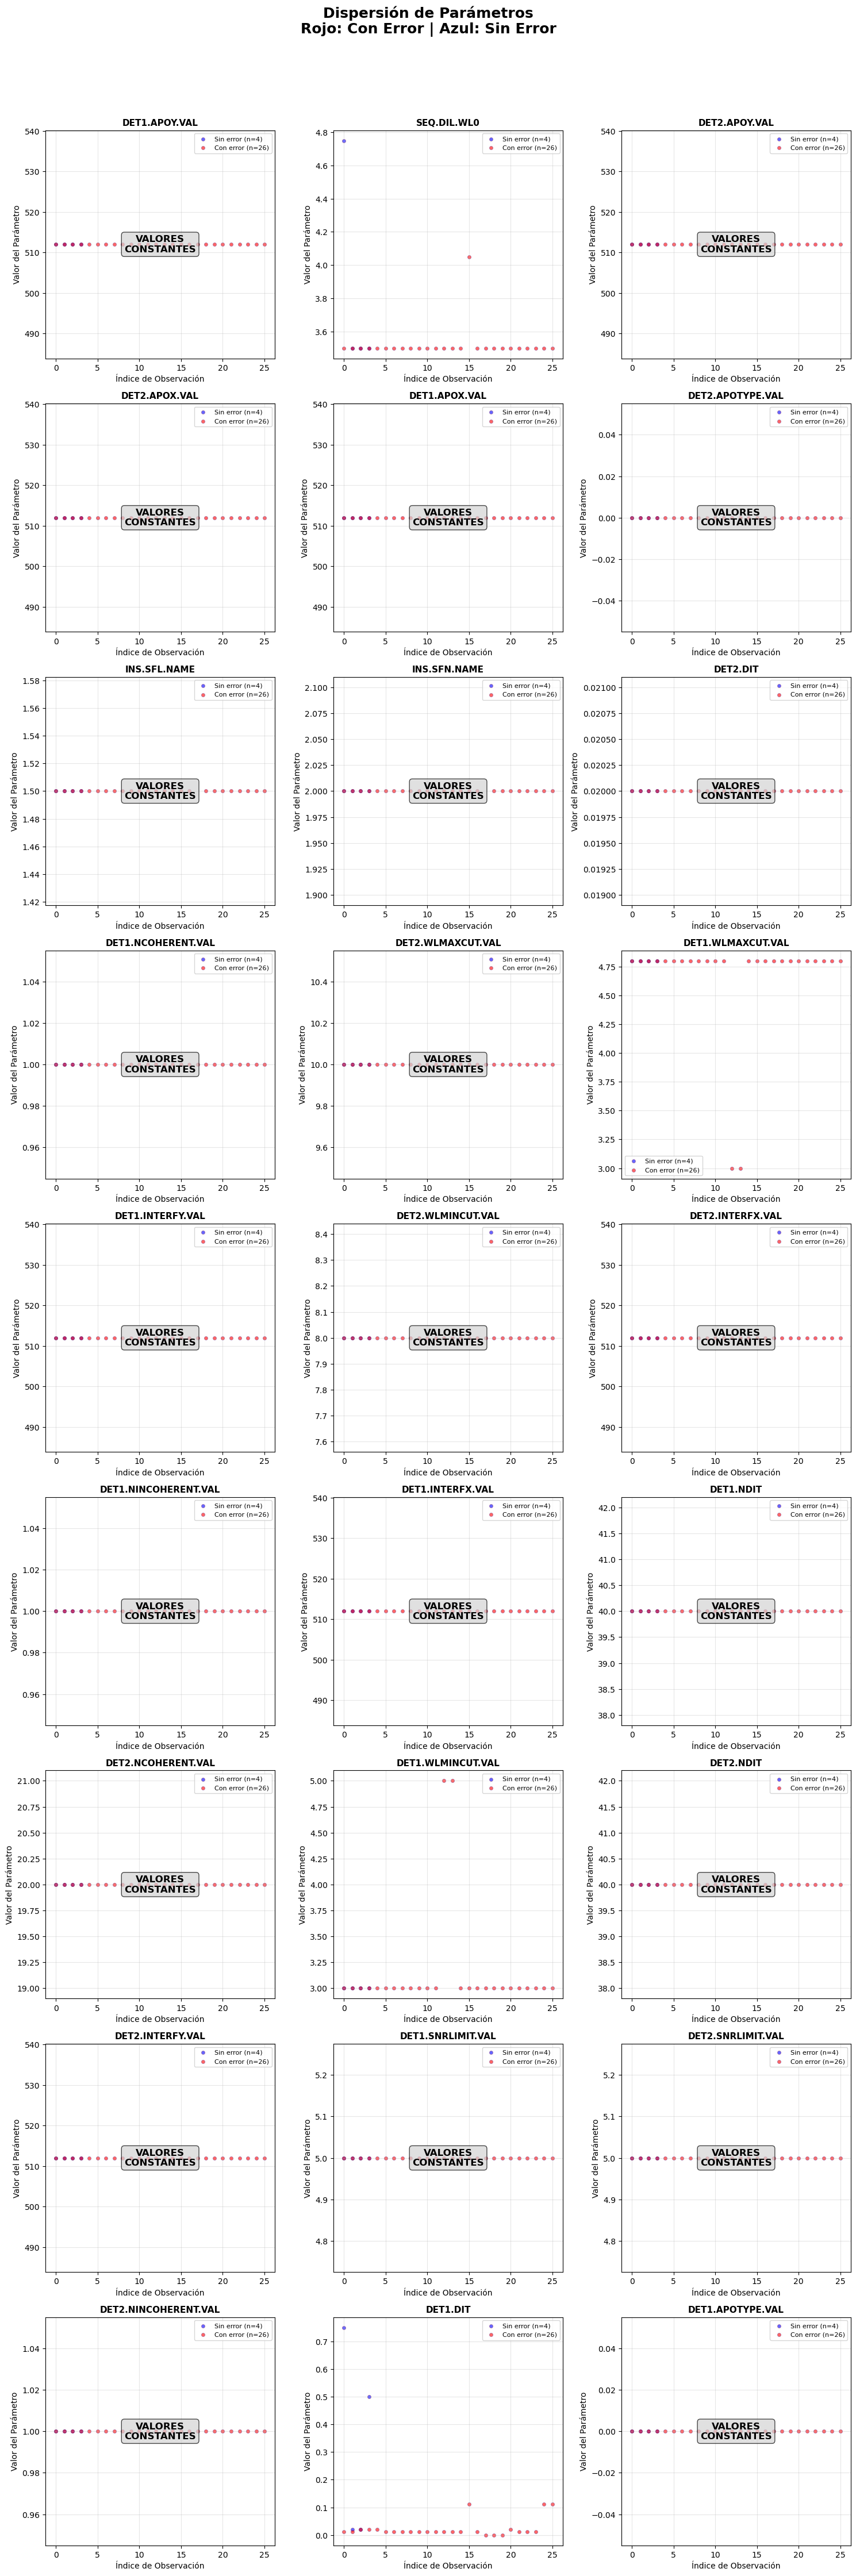


Comparando params_MATISSE_gen_cal_bias.csv
Creando gráficos para 3 parámetros...
Observaciones sin error: 715
Observaciones con error: 9


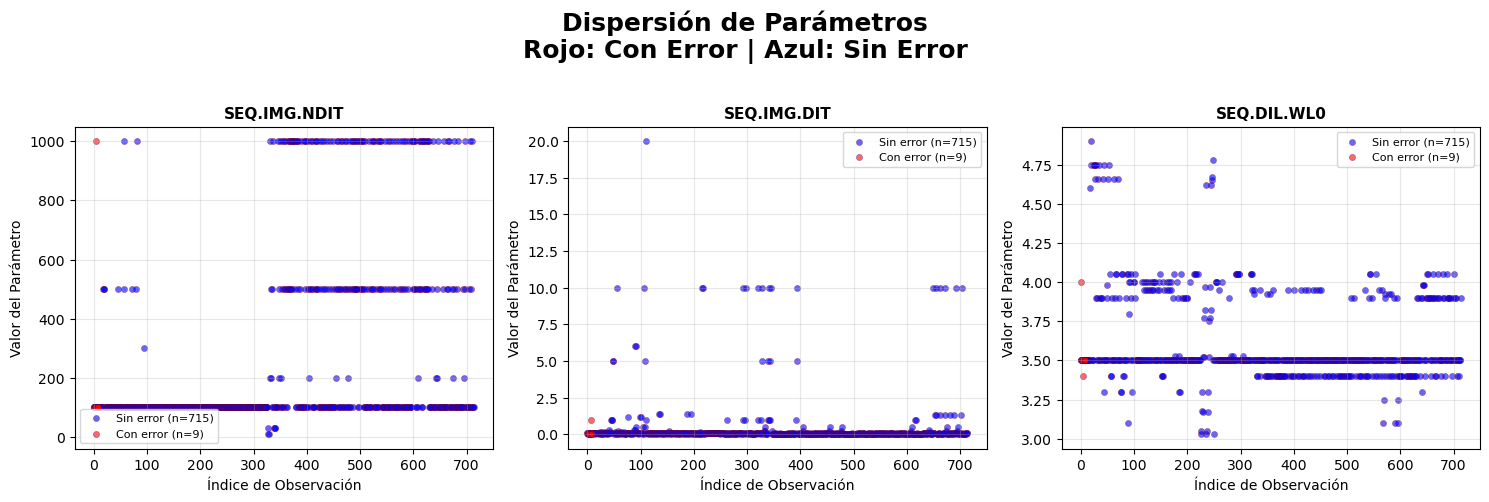


Comparando params_MATISSE_gen_cal_det_aq.csv
Creando gráficos para 12 parámetros...
Observaciones sin error: 7
Observaciones con error: 15


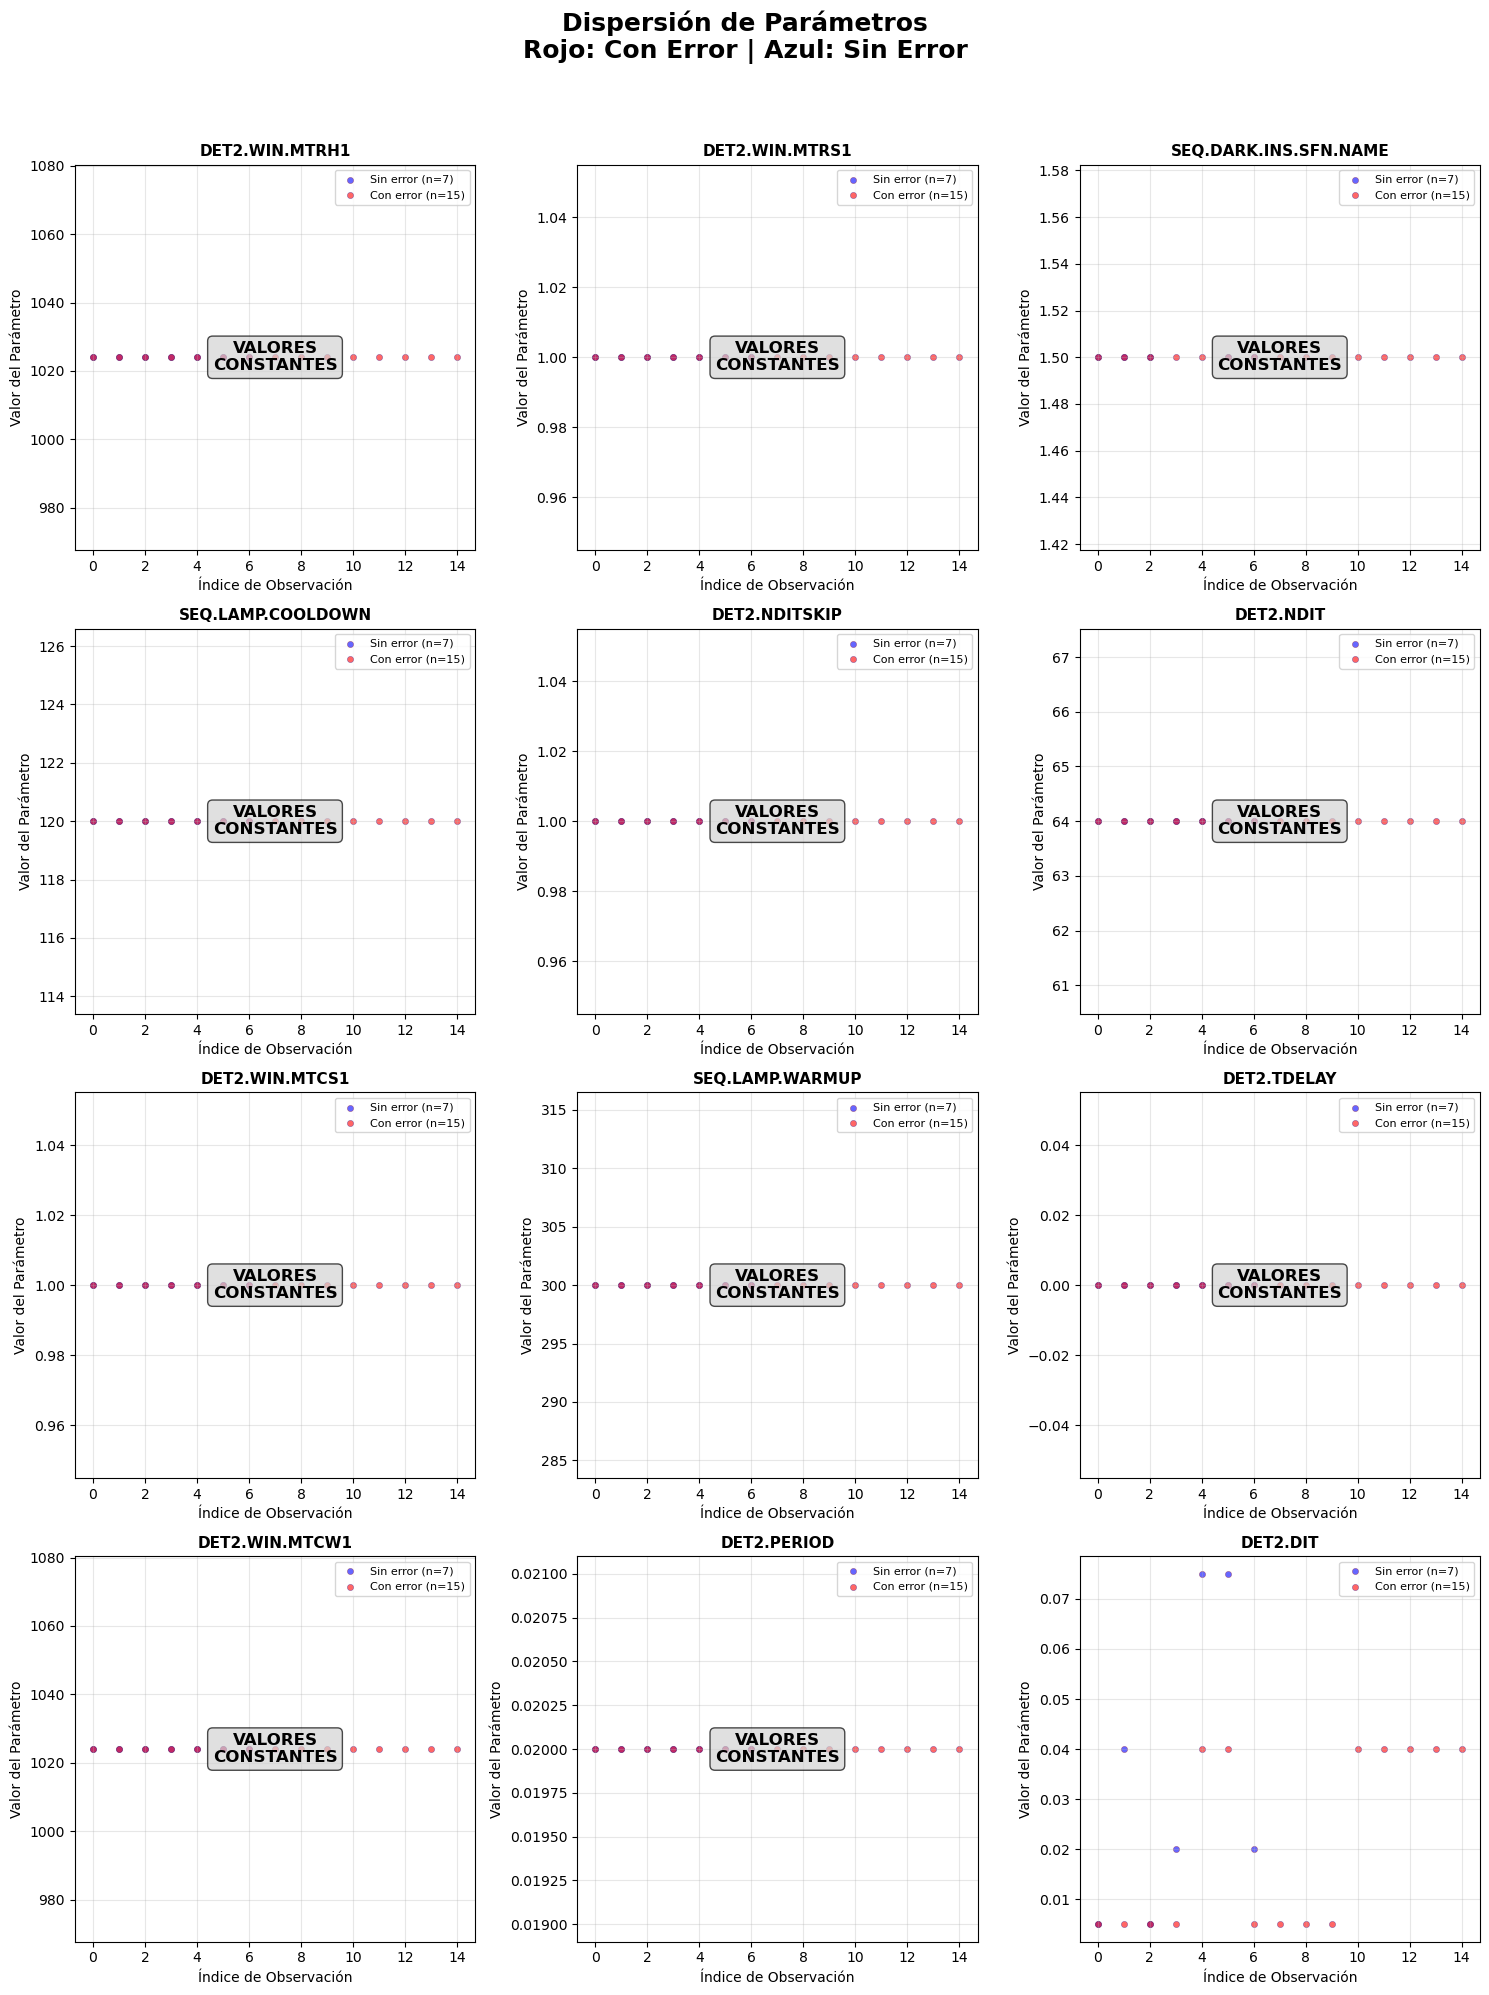


Comparando params_MATISSE_gen_cal_det_h2.csv
Creando gráficos para 13 parámetros...
Observaciones sin error: 18
Observaciones con error: 3


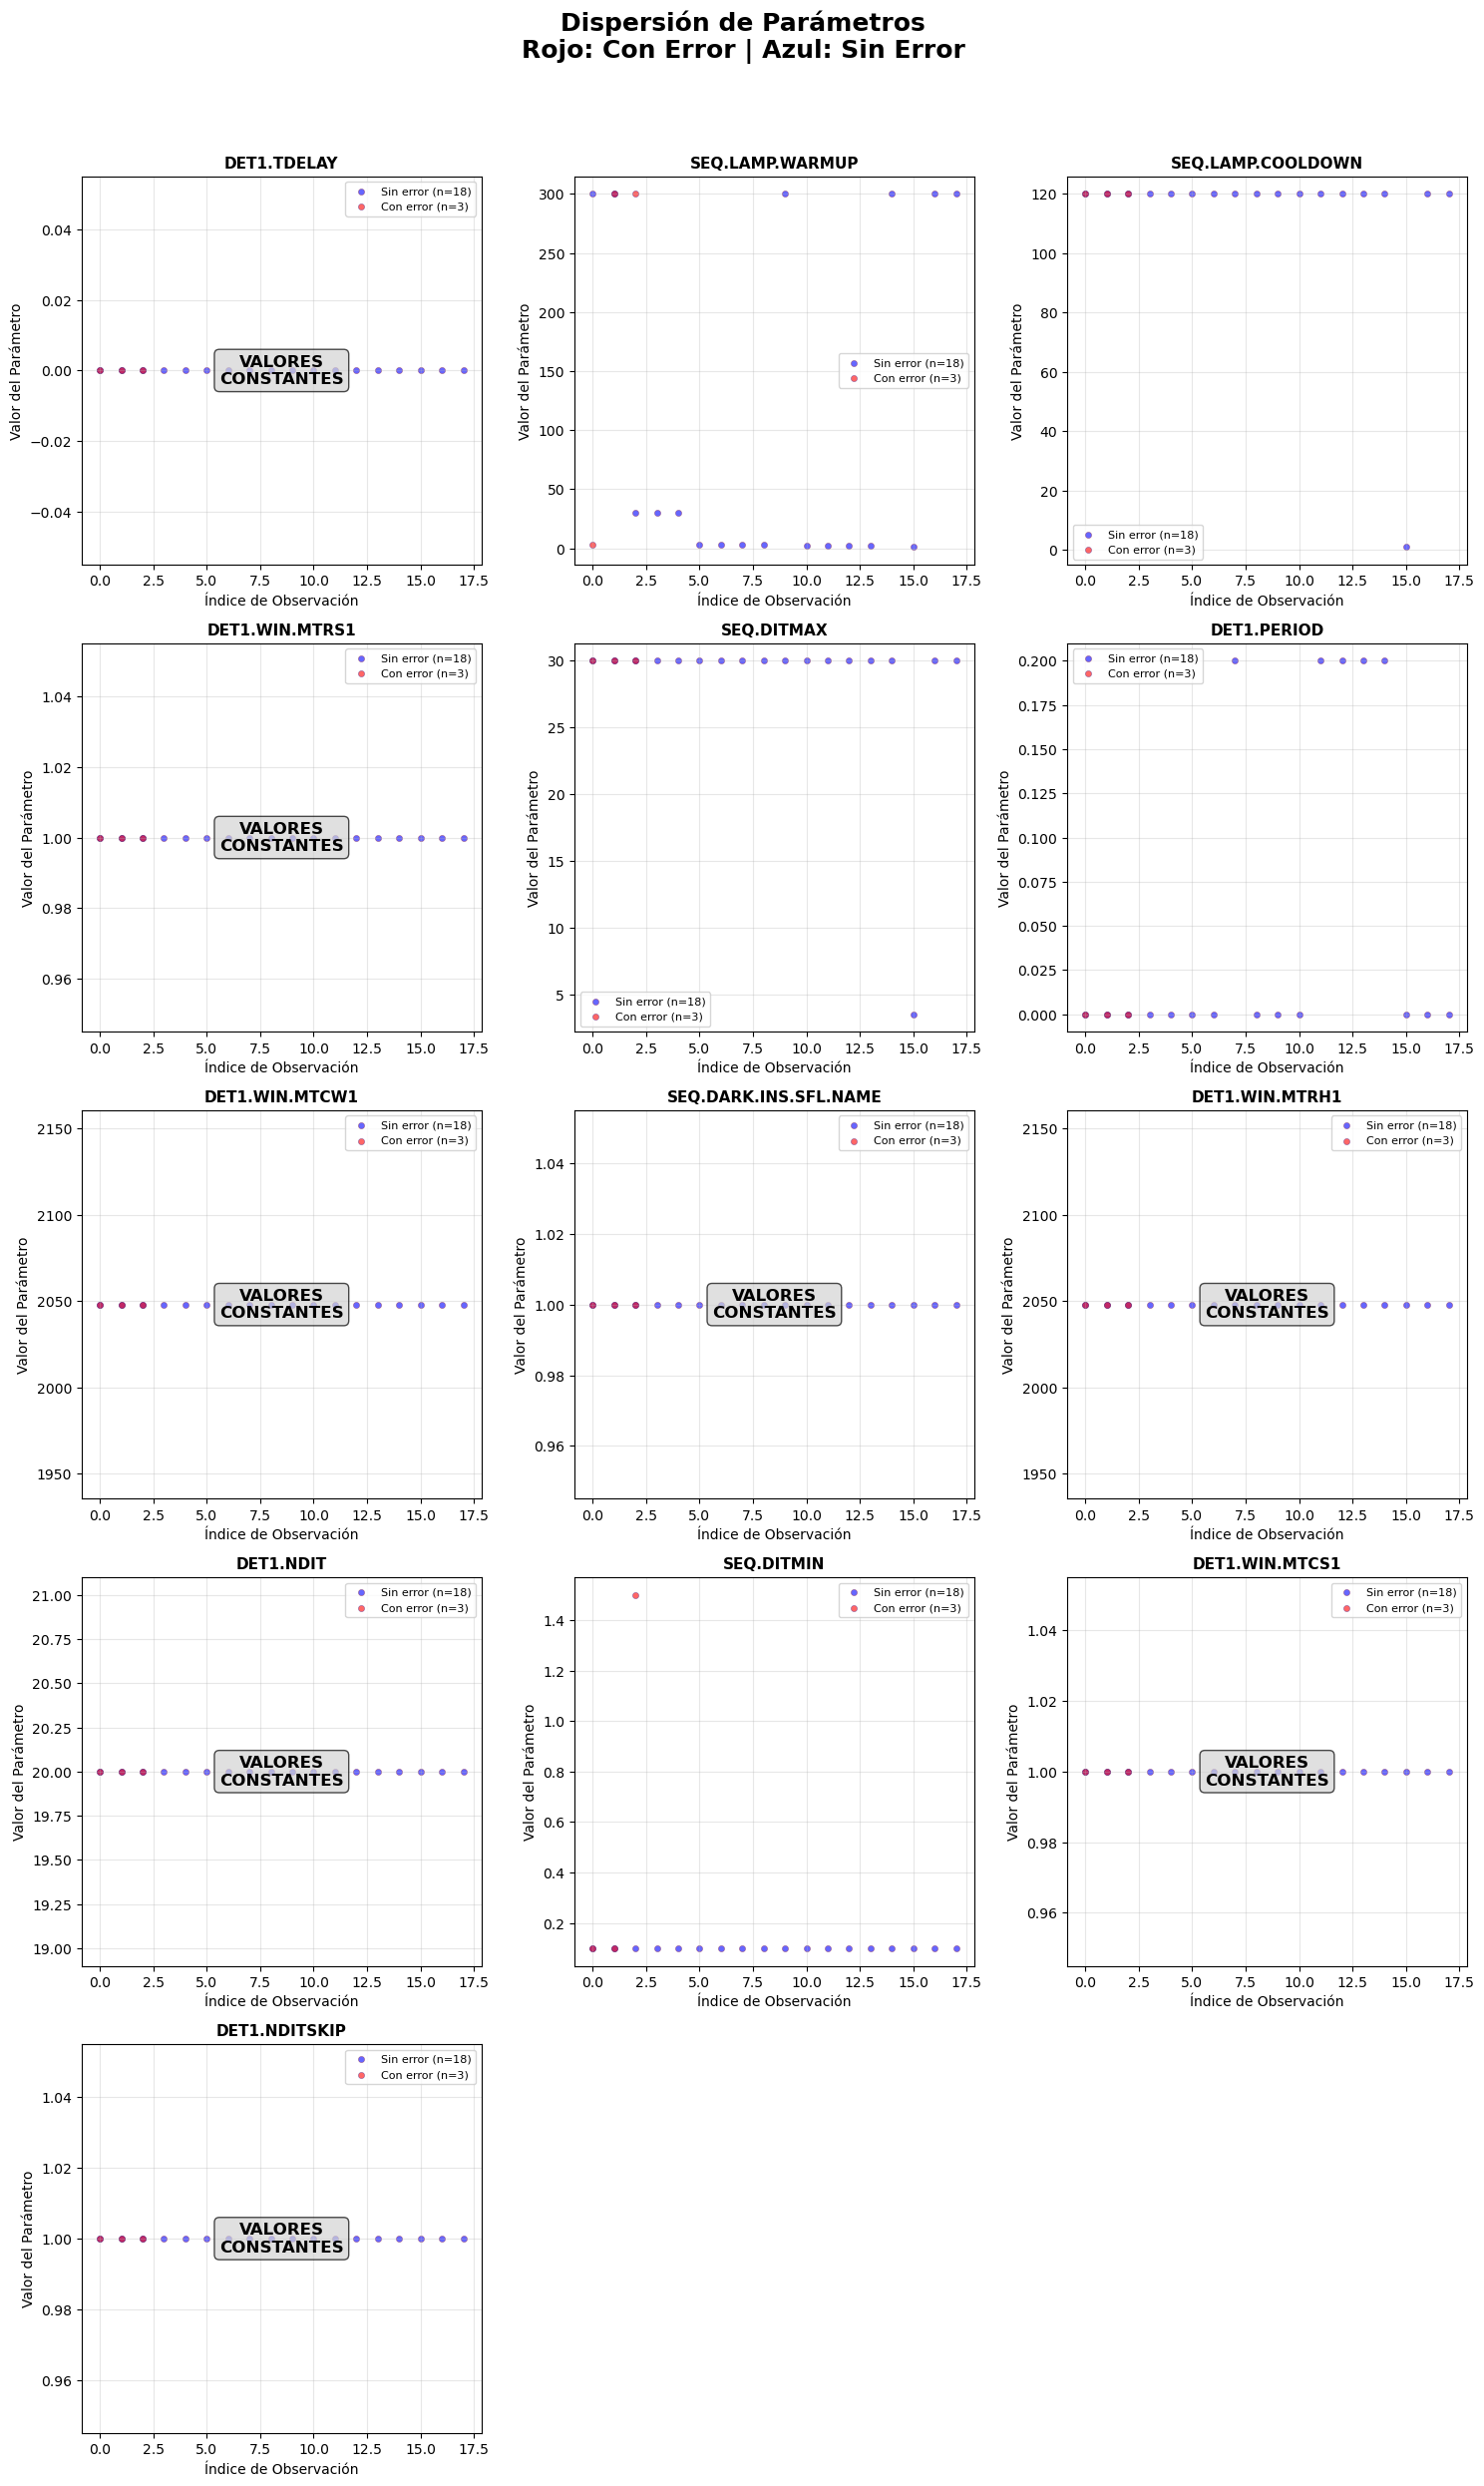


Comparando params_MATISSE_gen_cal_imbasic.csv
Creando gráficos para 21 parámetros...
Observaciones sin error: 393
Observaciones con error: 6


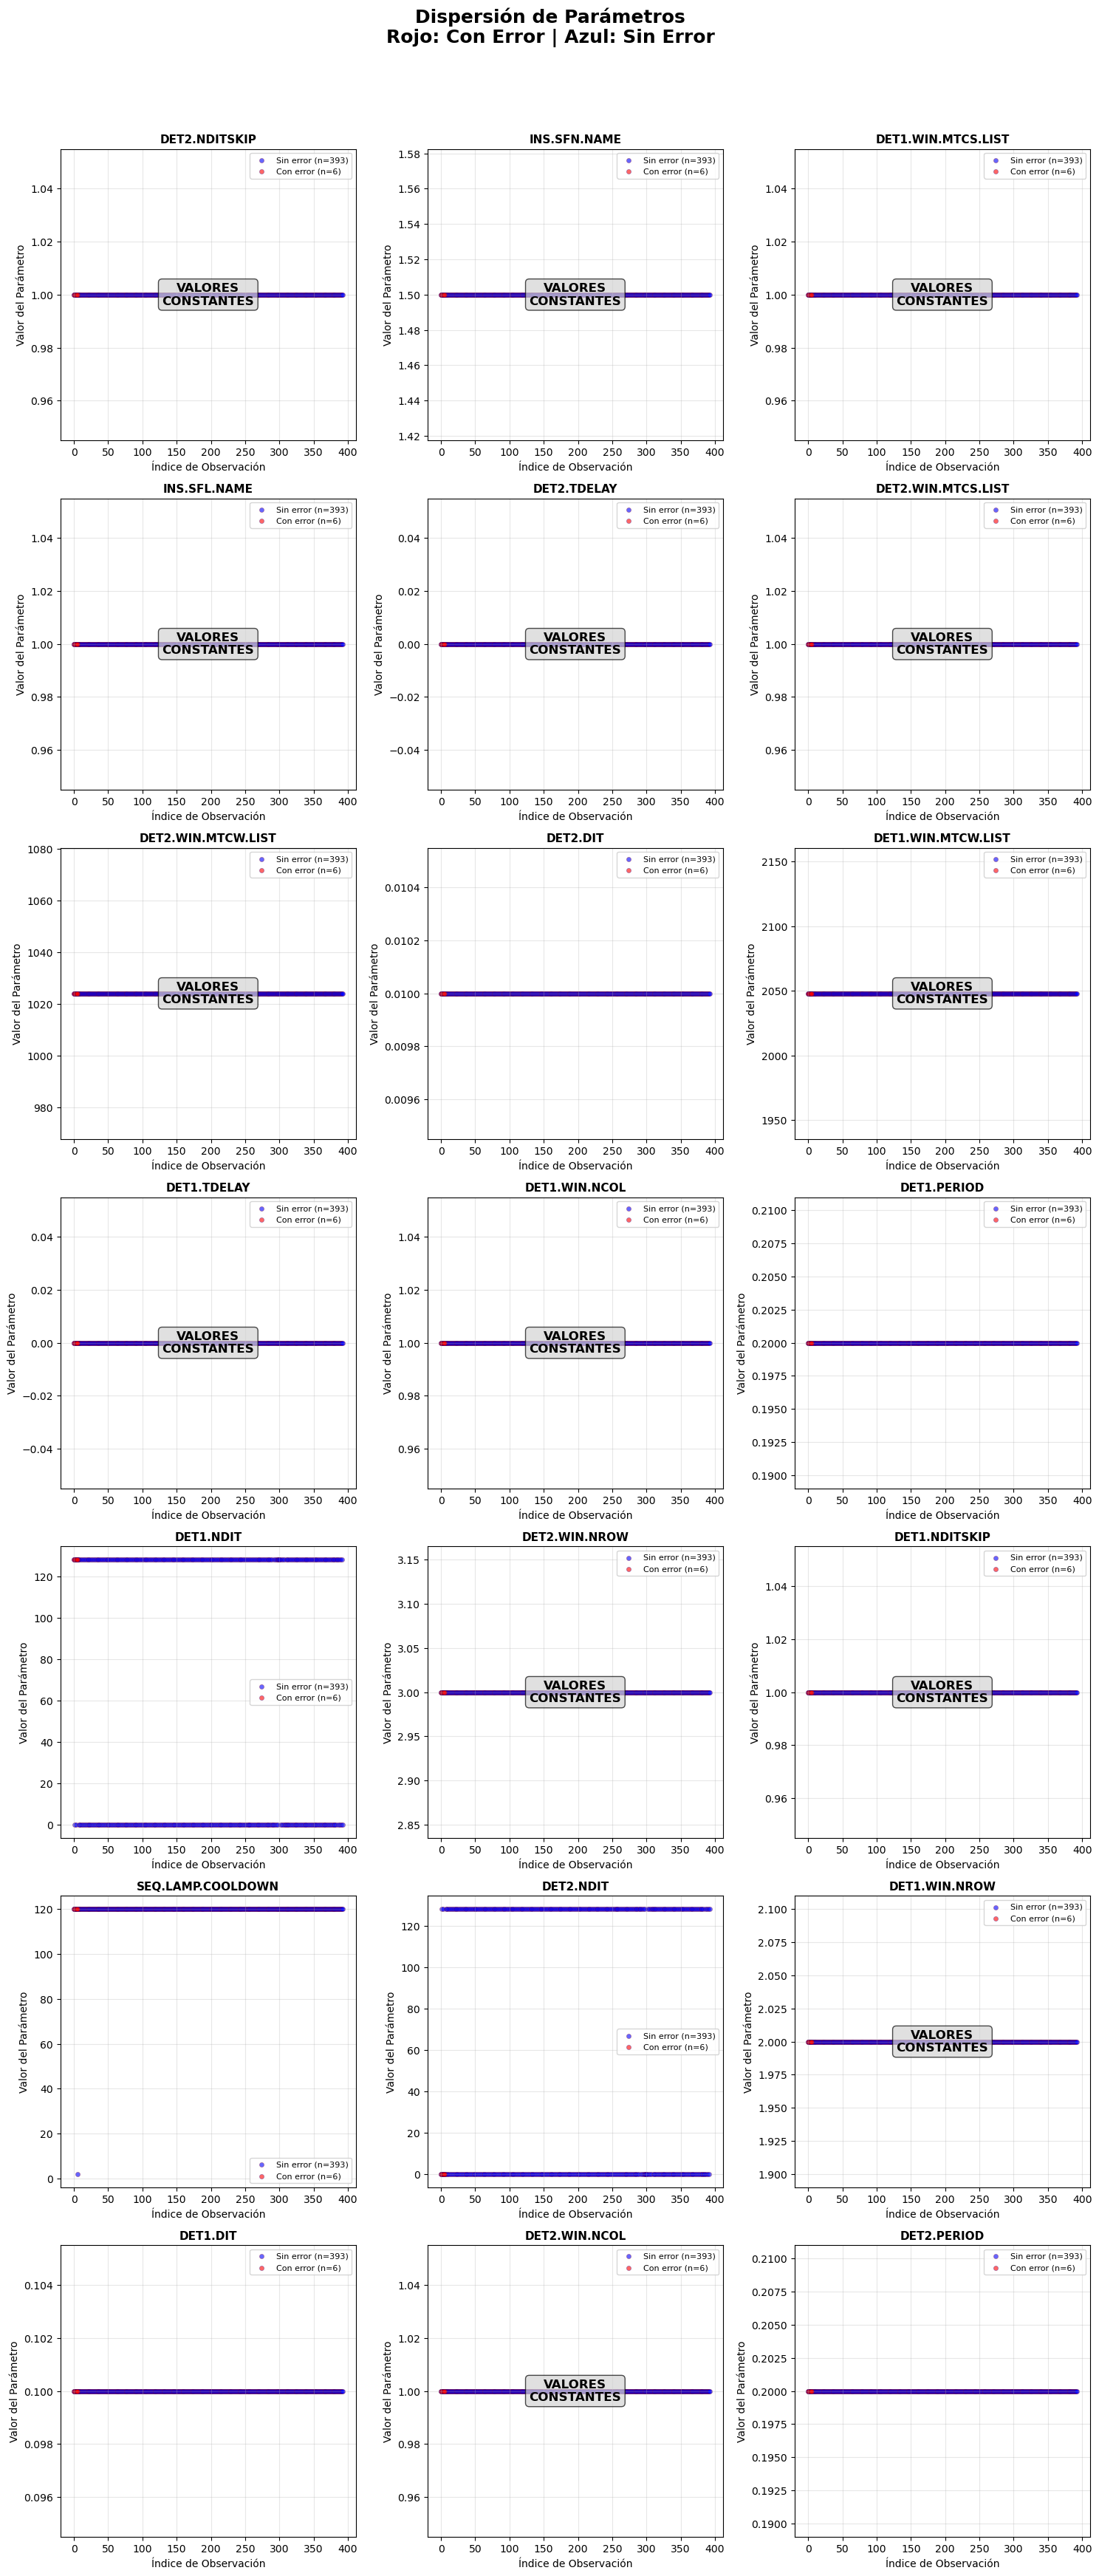


Comparando params_MATISSE_gen_cal_kappa.csv
Creando gráficos para 4 parámetros...
Observaciones sin error: 54
Observaciones con error: 2


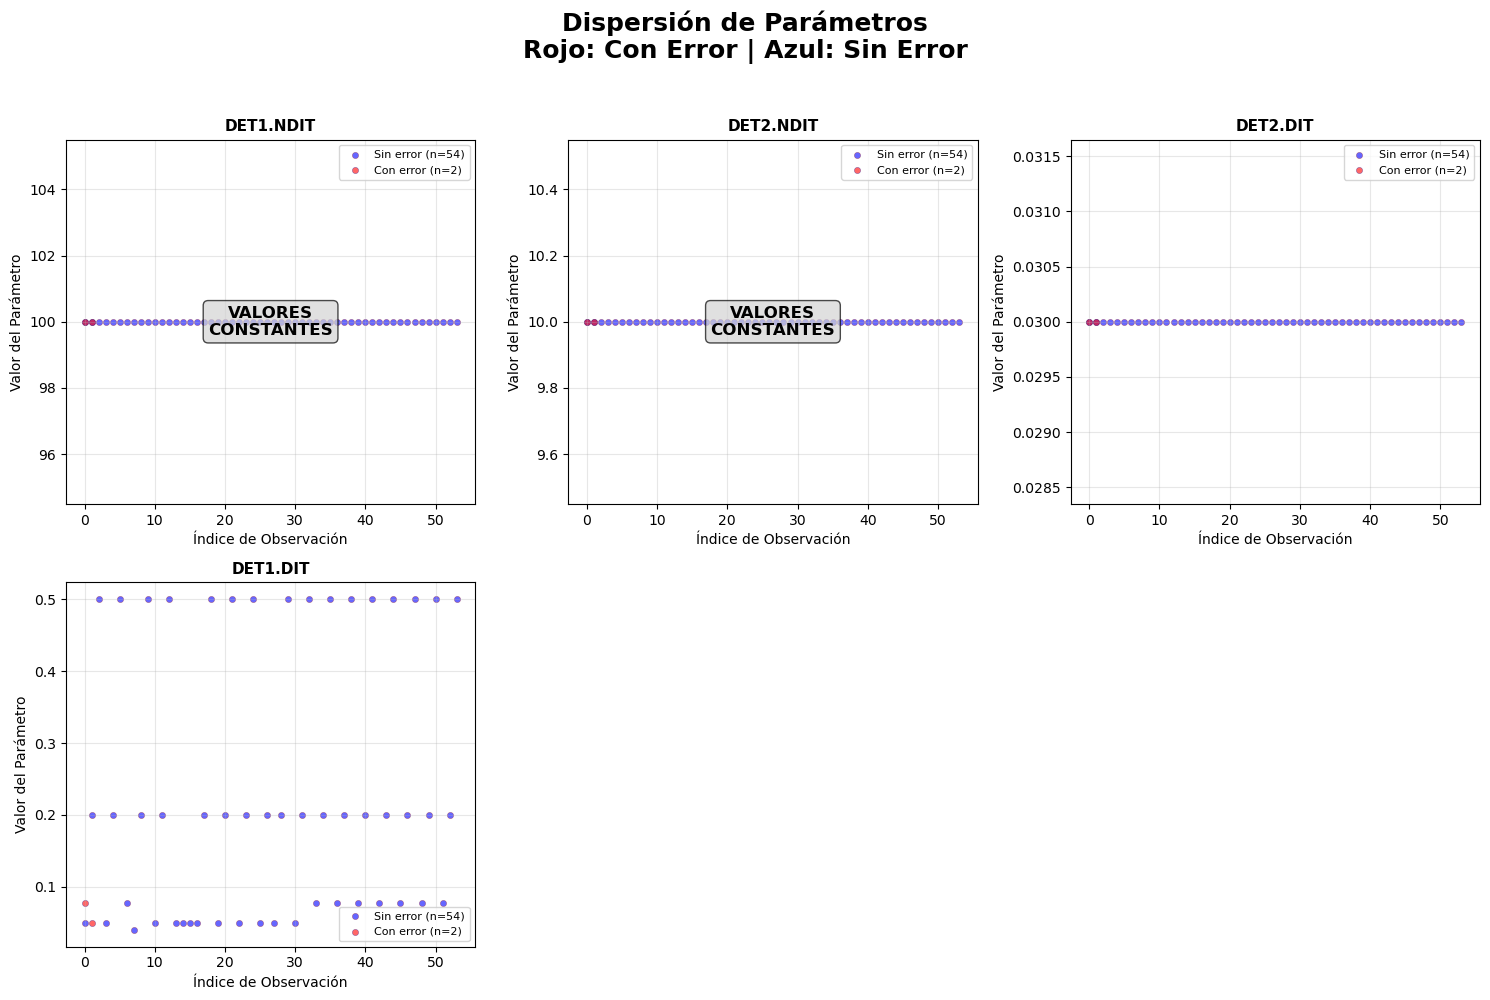


Comparando params_MATISSE_gen_cal_shift.csv
Creando gráficos para 4 parámetros...
Observaciones sin error: 47
Observaciones con error: 3


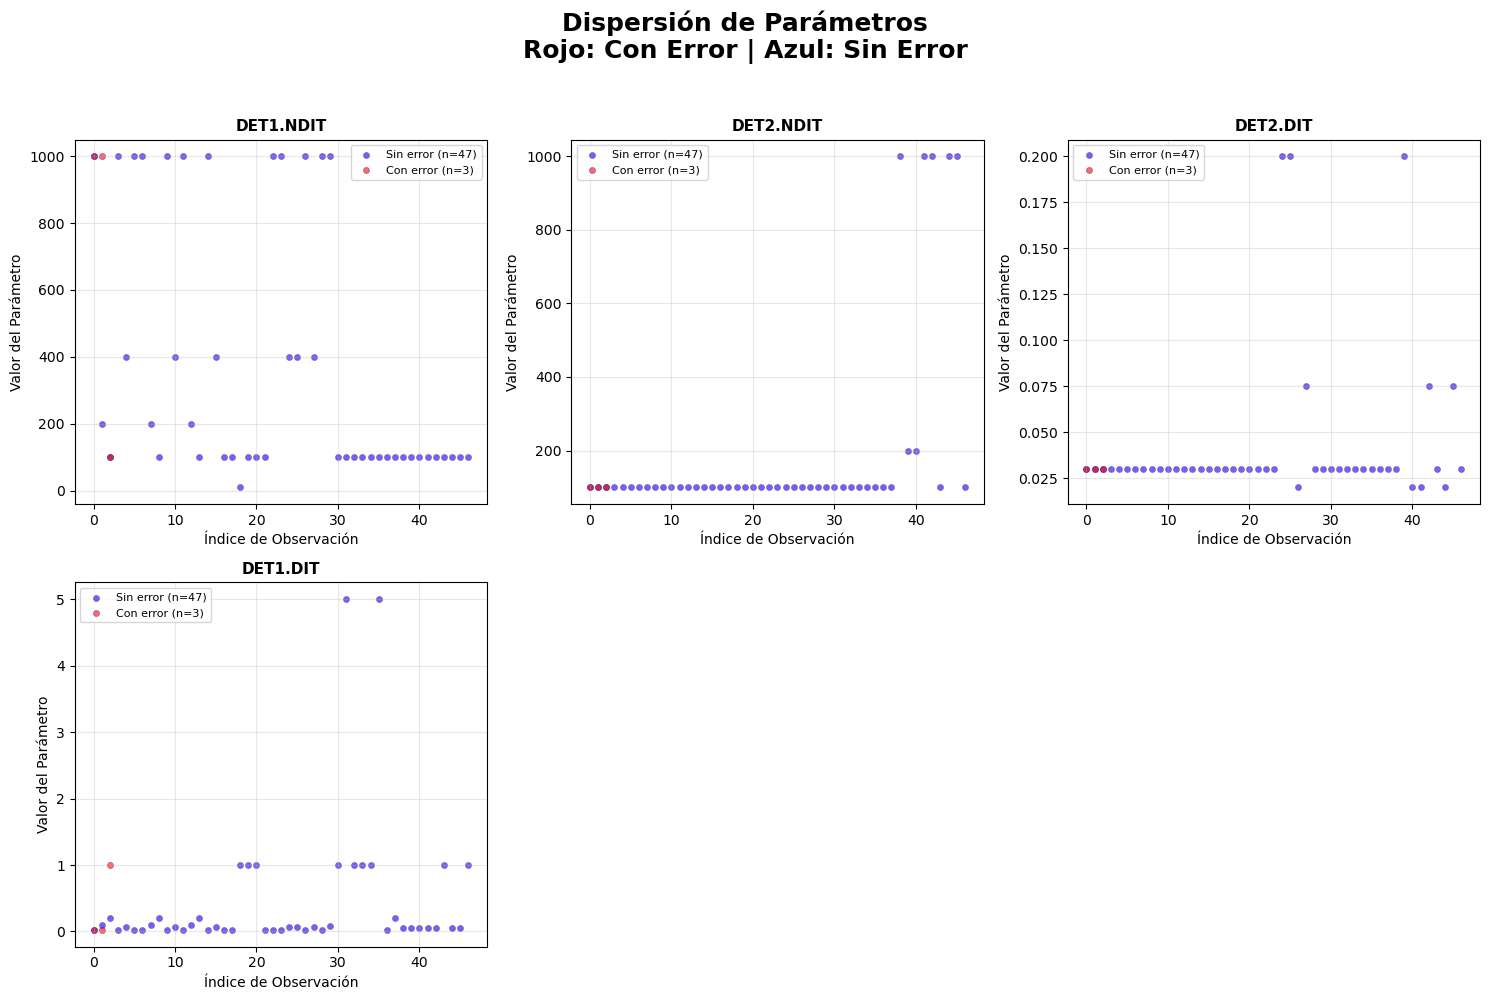


Comparando params_MATISSE_gen_cal_transfunc.csv
Creando gráficos para 37 parámetros...
Observaciones sin error: 240
Observaciones con error: 1


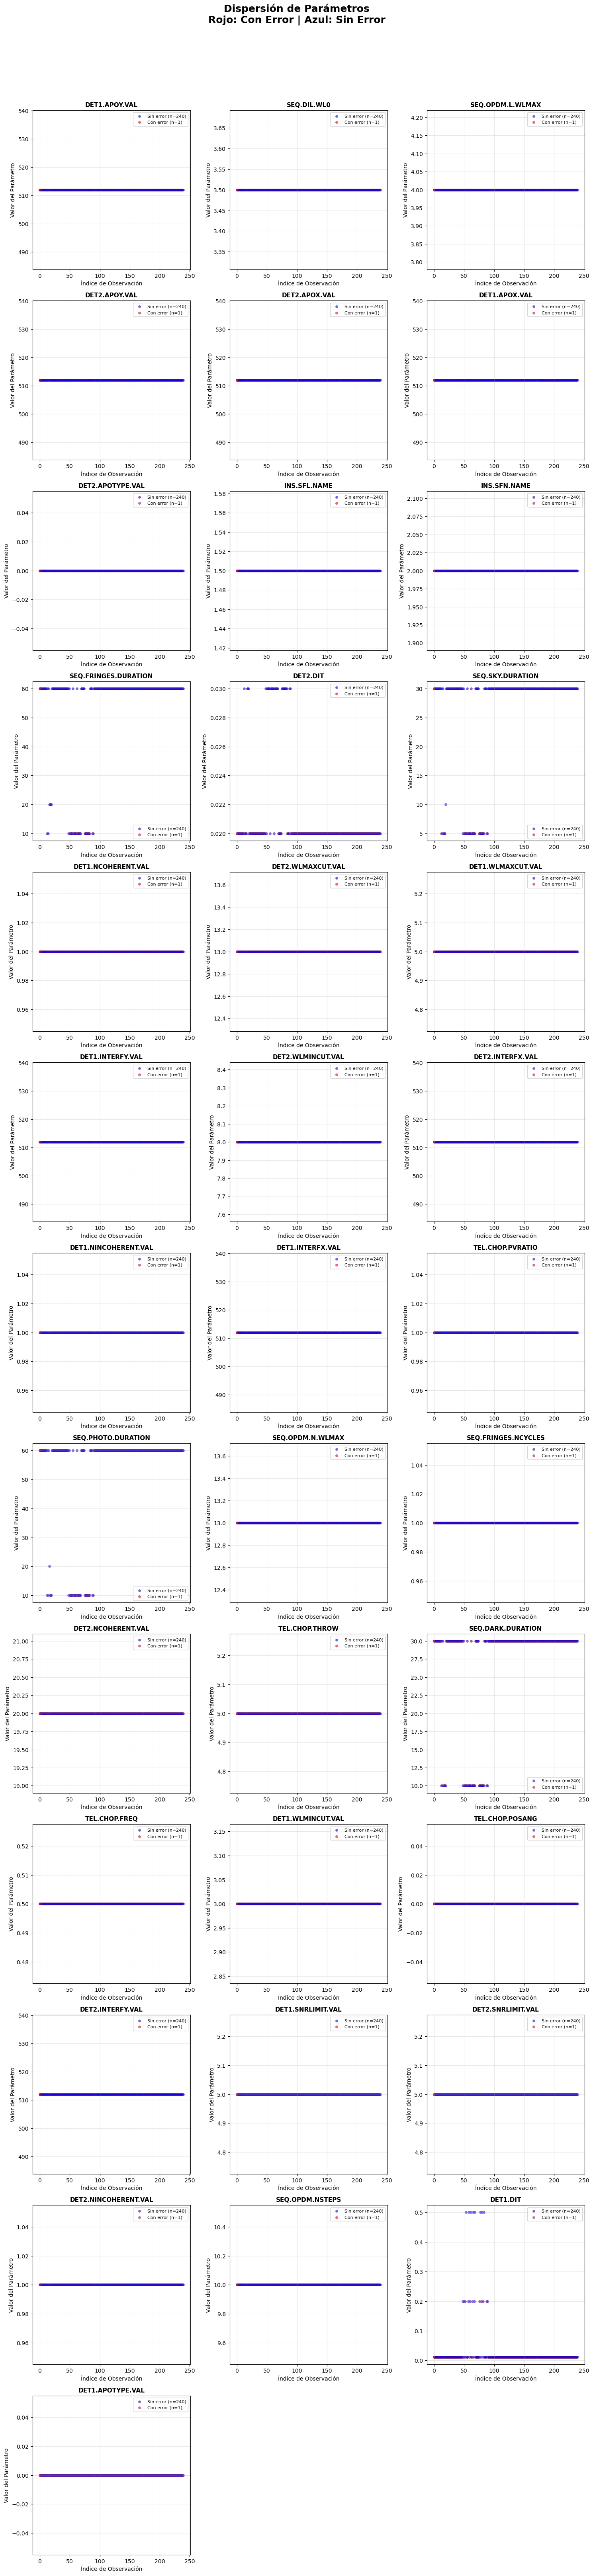


Comparando params_MATISSE_gen_tec_ali.csv
Creando gráficos para 8 parámetros...
Observaciones sin error: 116
Observaciones con error: 67


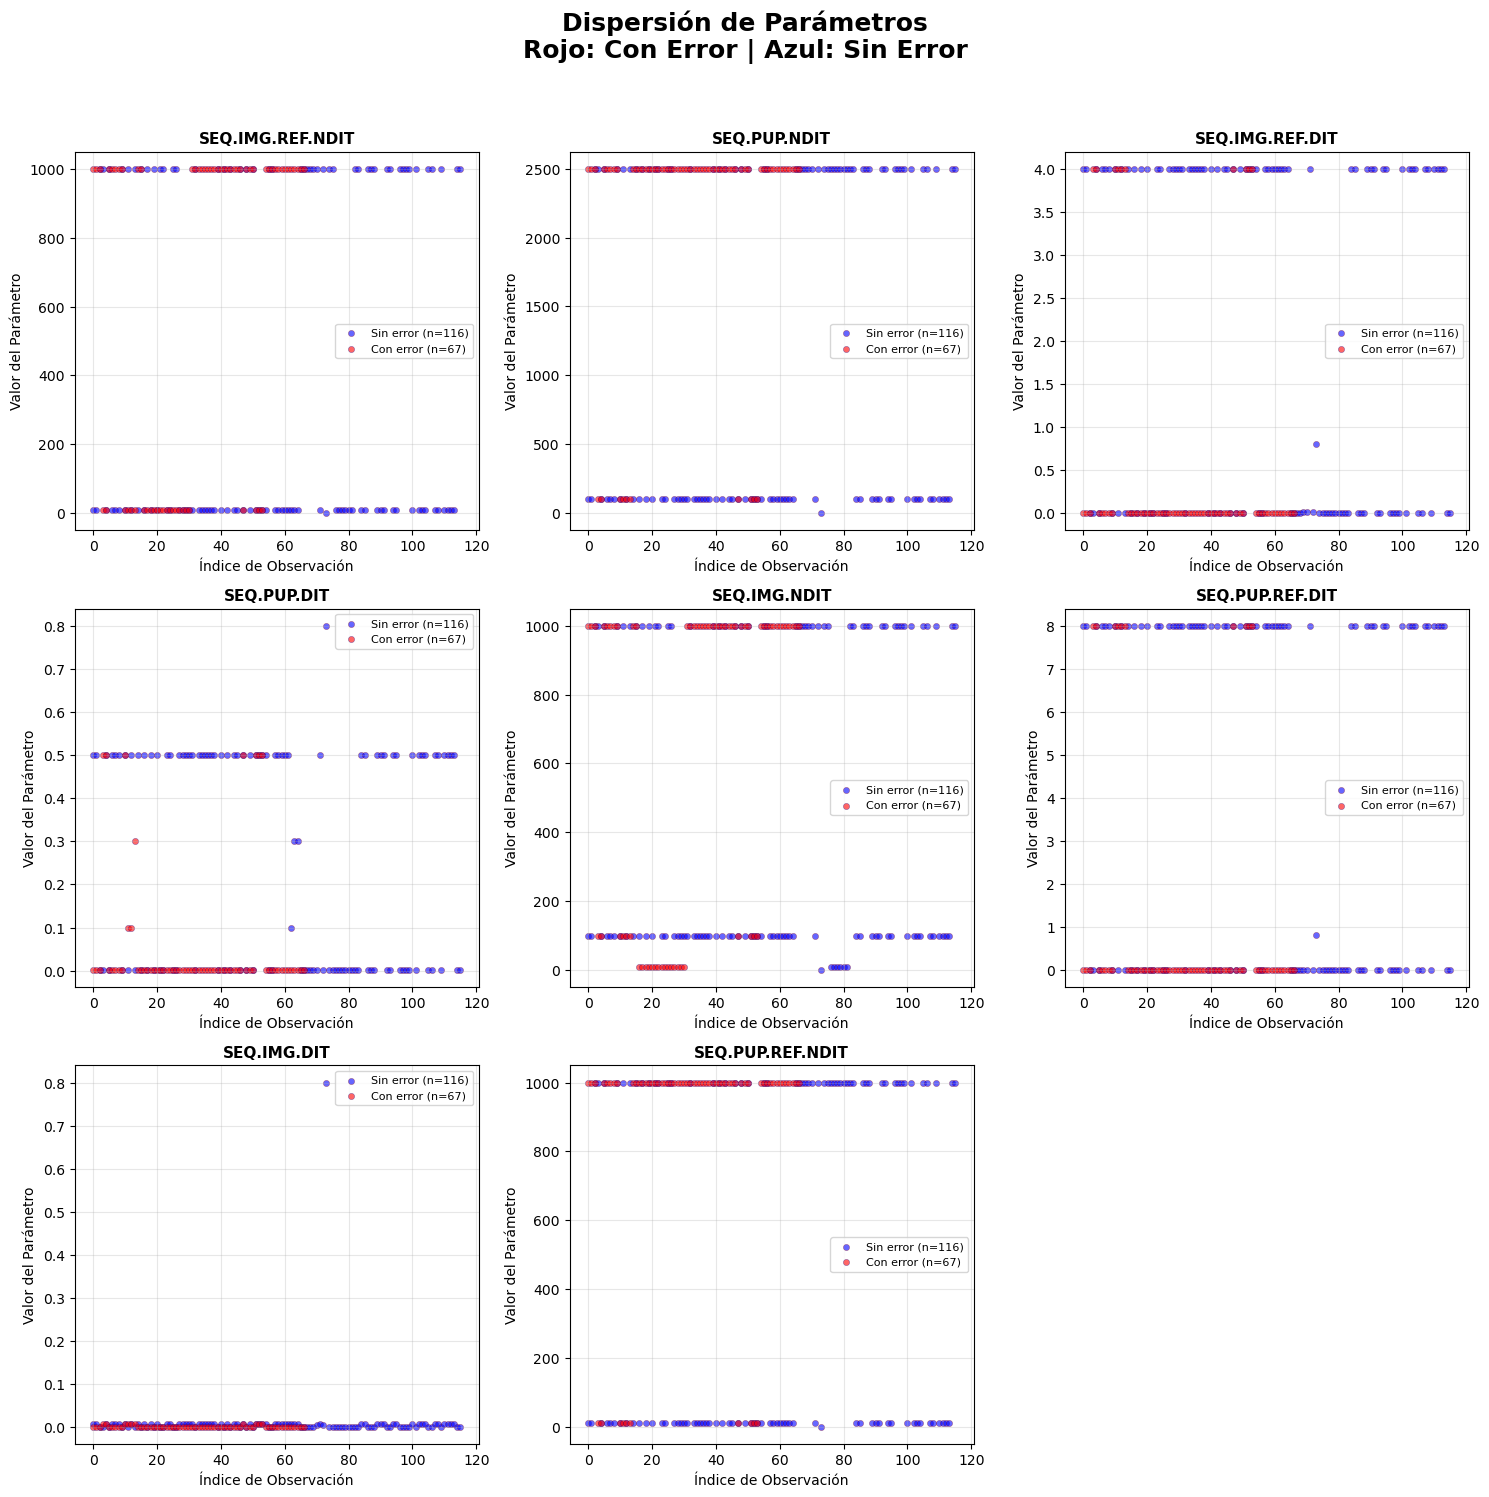


Comparando params_MATISSE_gen_tec_check_fringes.csv
Creando gráficos para 27 parámetros...
Observaciones sin error: 173
Observaciones con error: 10


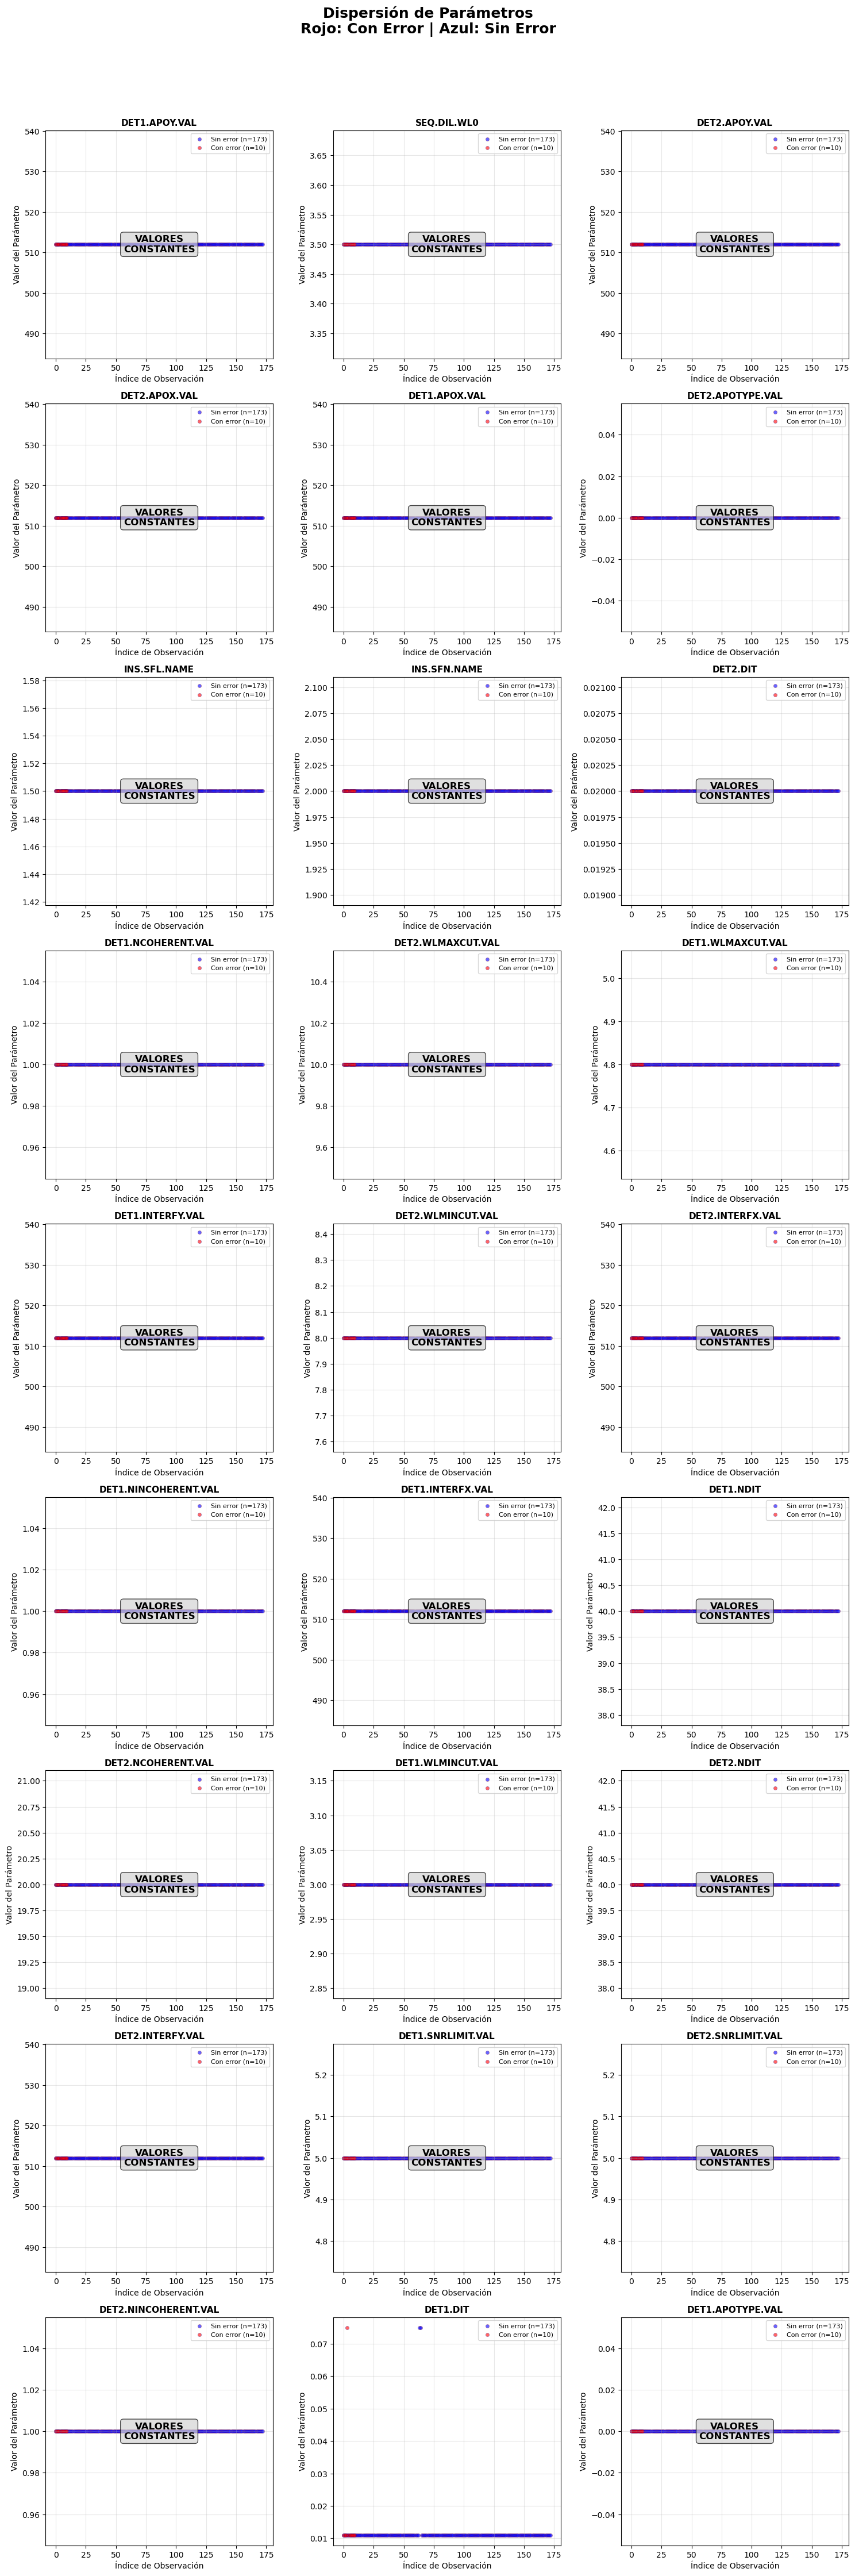


Comparando params_MATISSE_gen_tec_opd.csv
Creando gráficos para 26 parámetros...
Observaciones sin error: 1035
Observaciones con error: 20


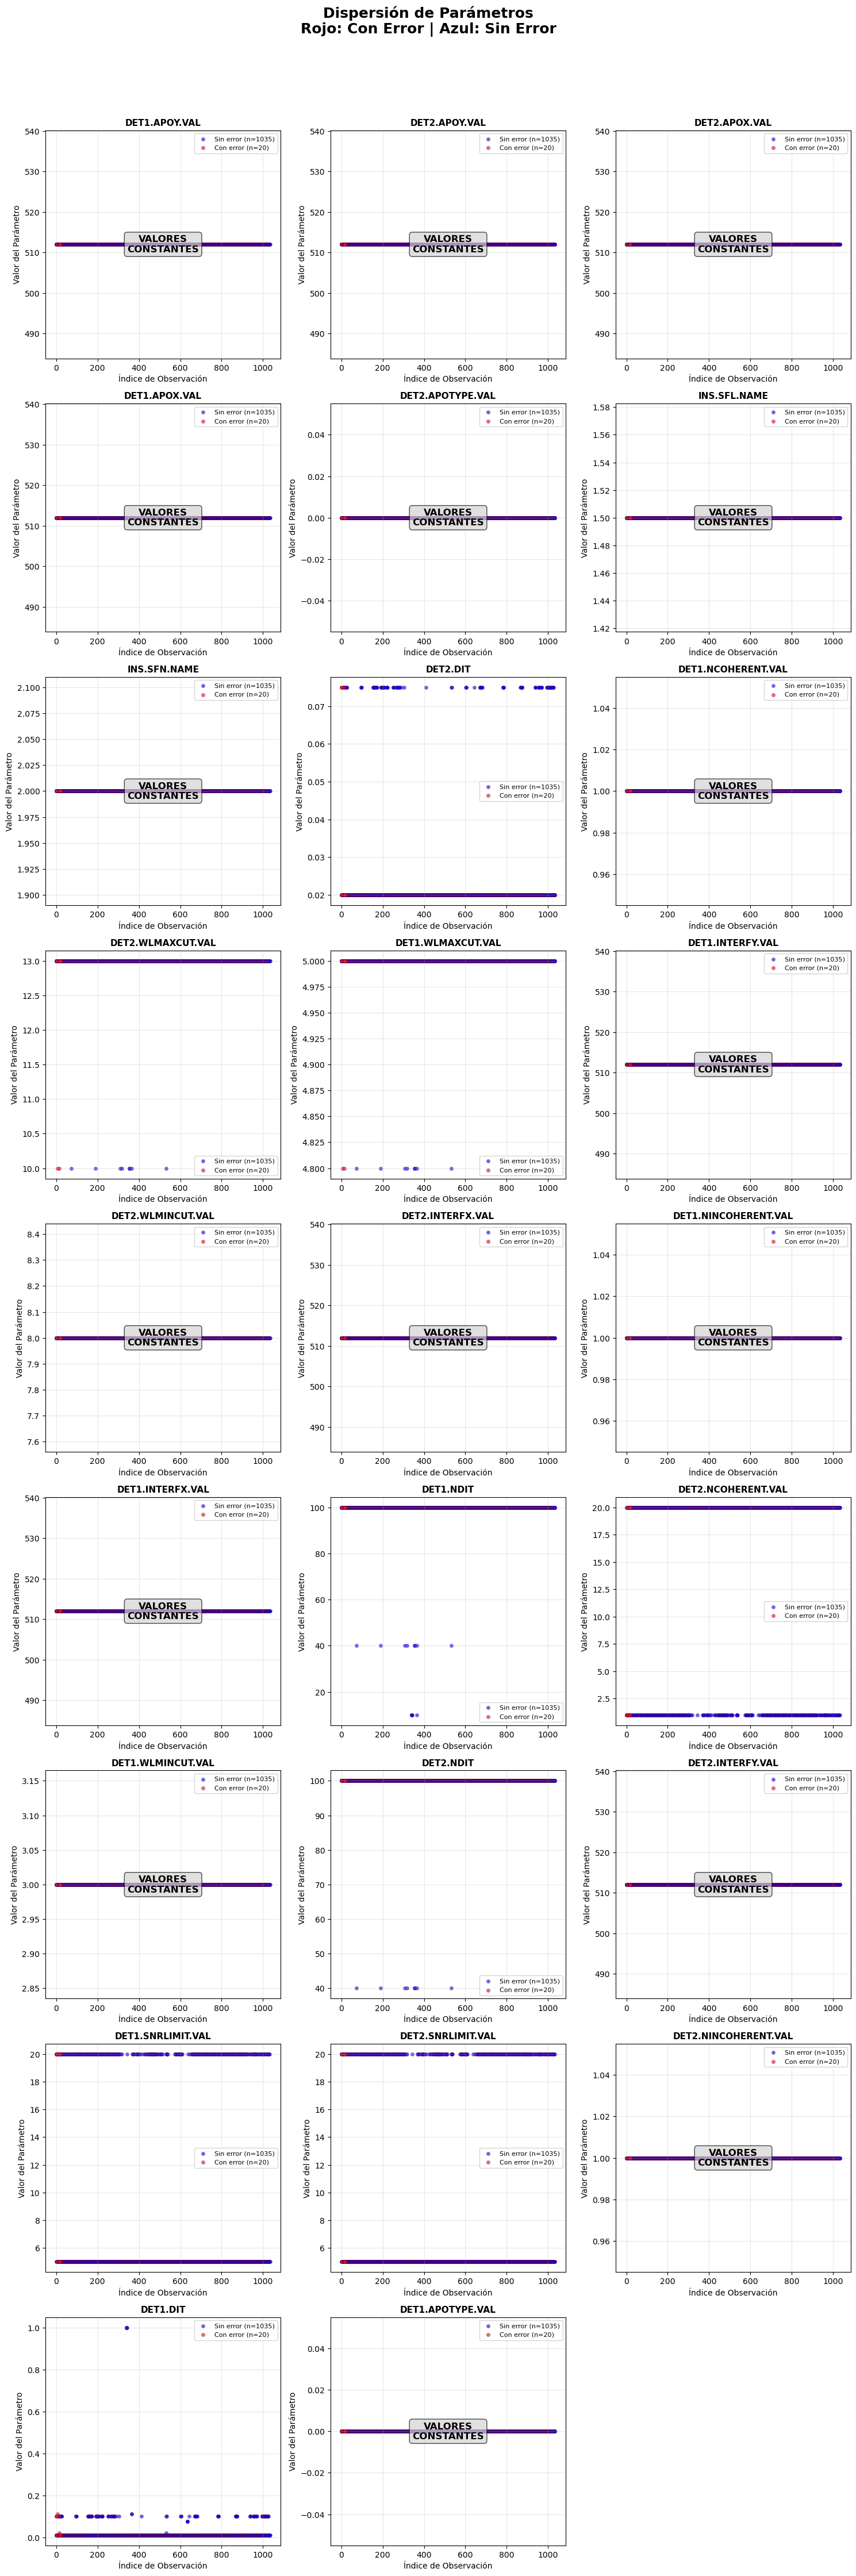


Comparando params_MATISSE_gen_tec_piezos.csv
Creando gráficos para 9 parámetros...
Observaciones sin error: 11
Observaciones con error: 2


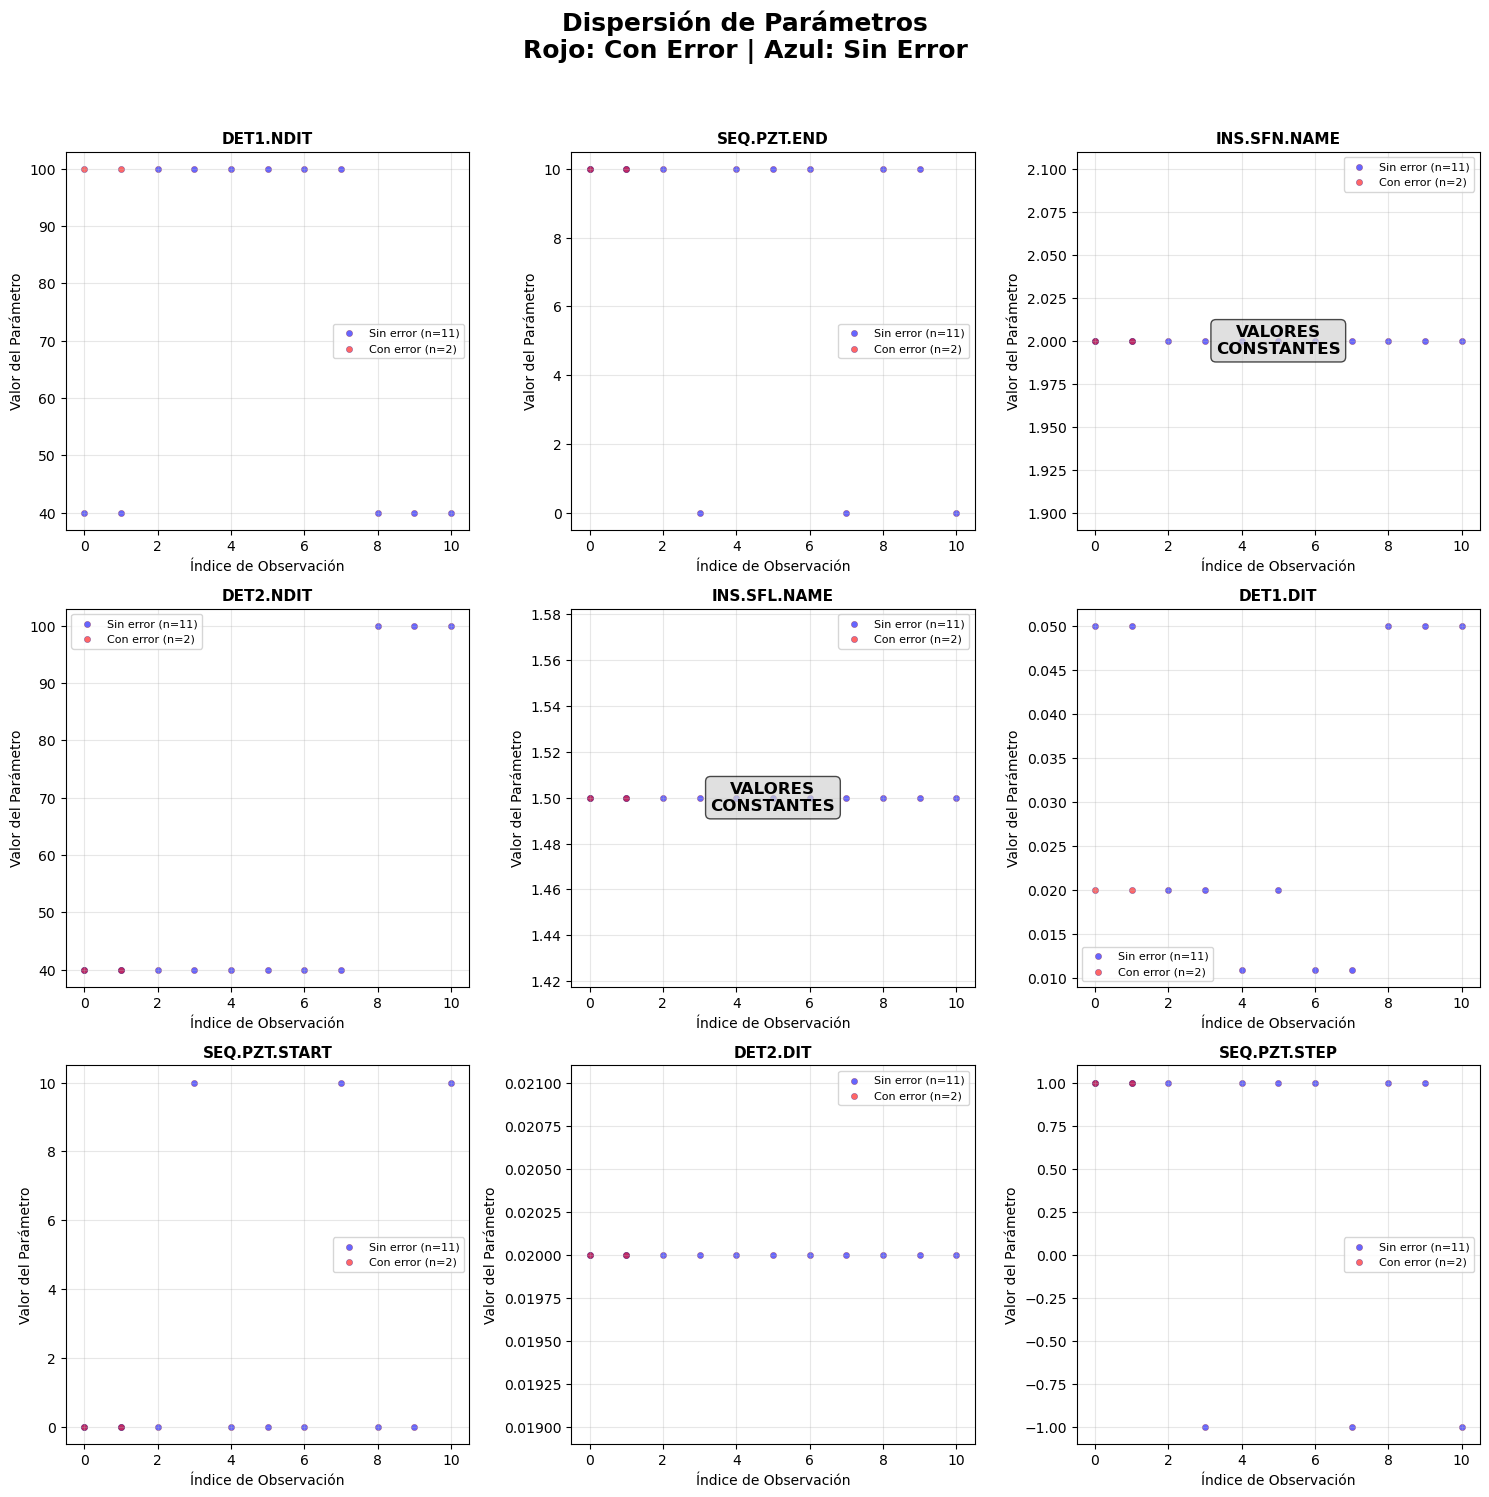


Comparando params_MATISSE_hyb_obs.csv
Creando gráficos para 36 parámetros...
Observaciones sin error: 1569
Observaciones con error: 43


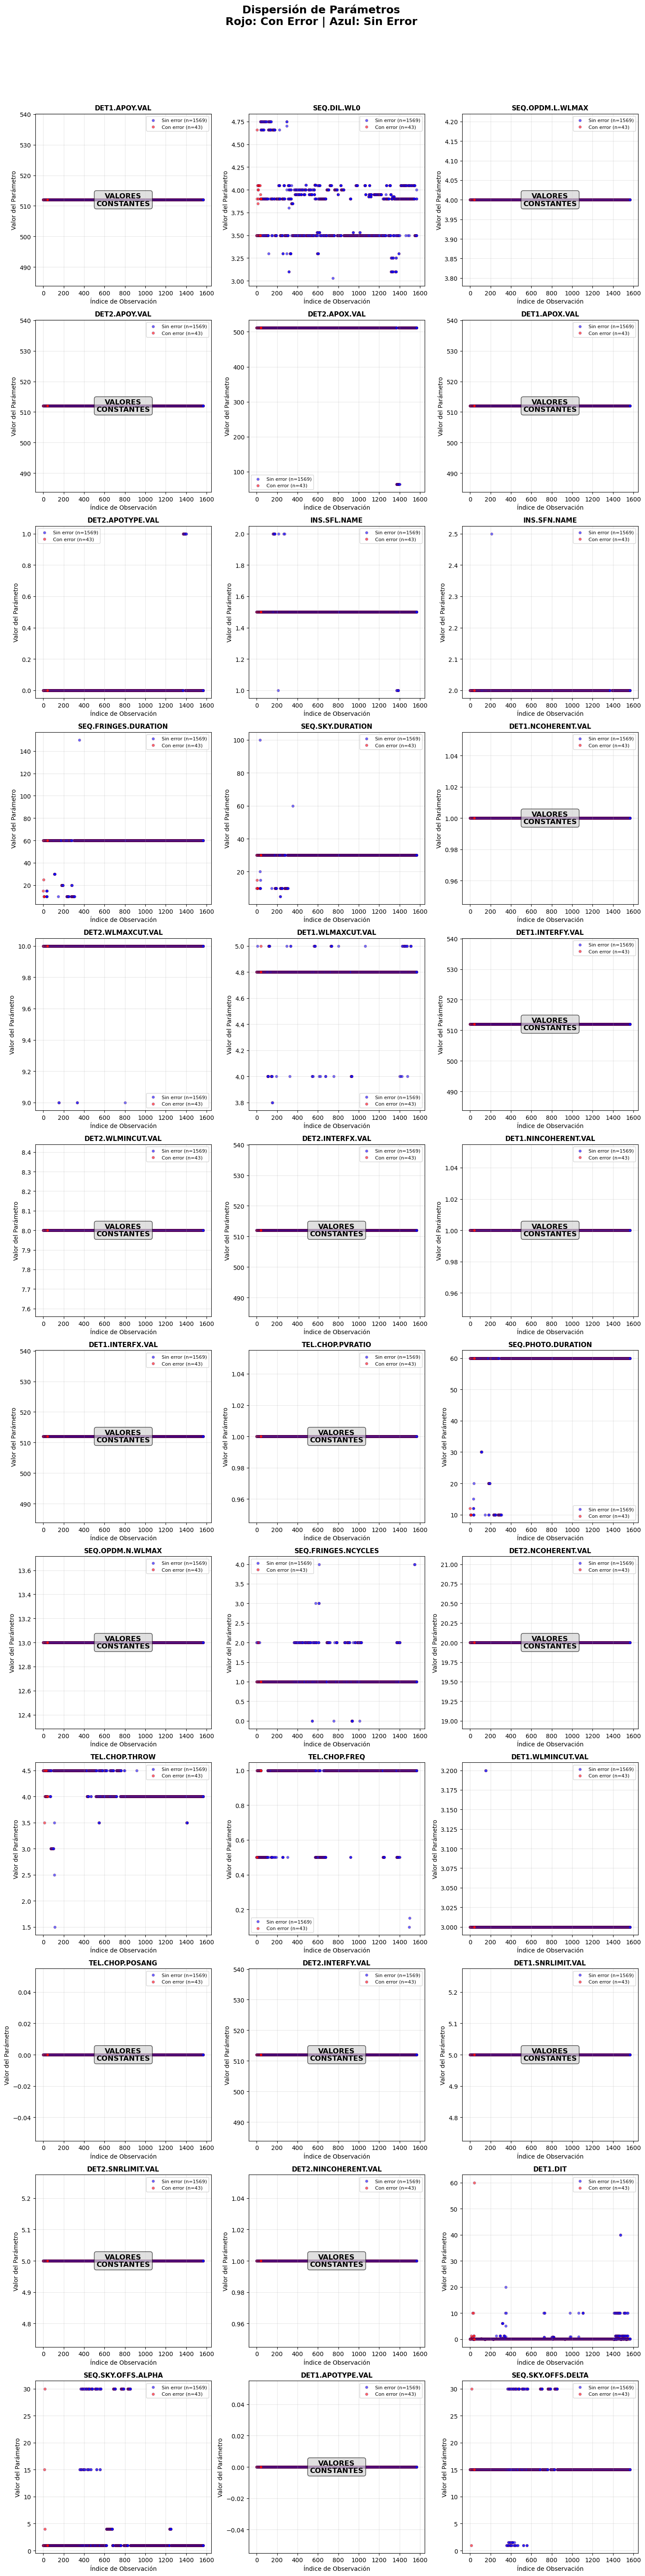


Comparando params_MATISSE_img_acq.csv
Creando gráficos para 62 parámetros...
Observaciones sin error: 1425
Observaciones con error: 38


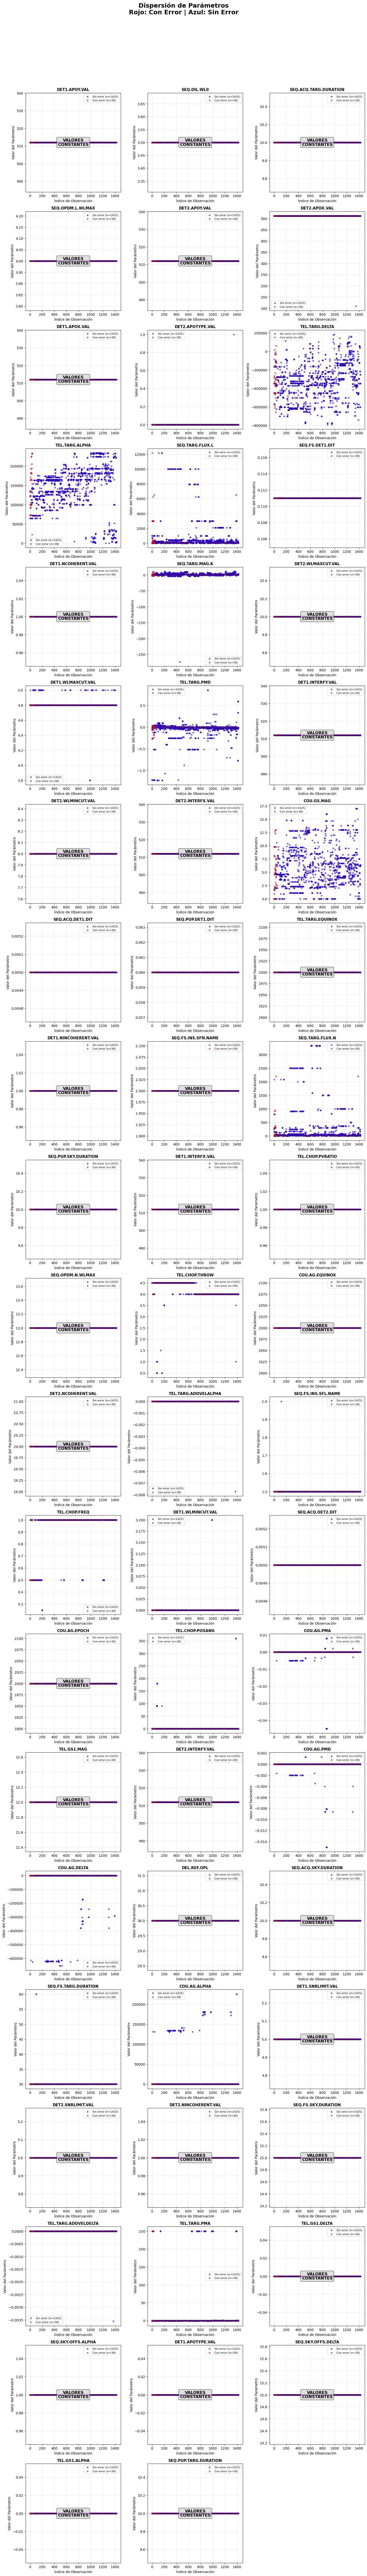


Comparando params_MATISSE_img_acq_ft.csv
Creando gráficos para 60 parámetros...
Observaciones sin error: 149
Observaciones con error: 21


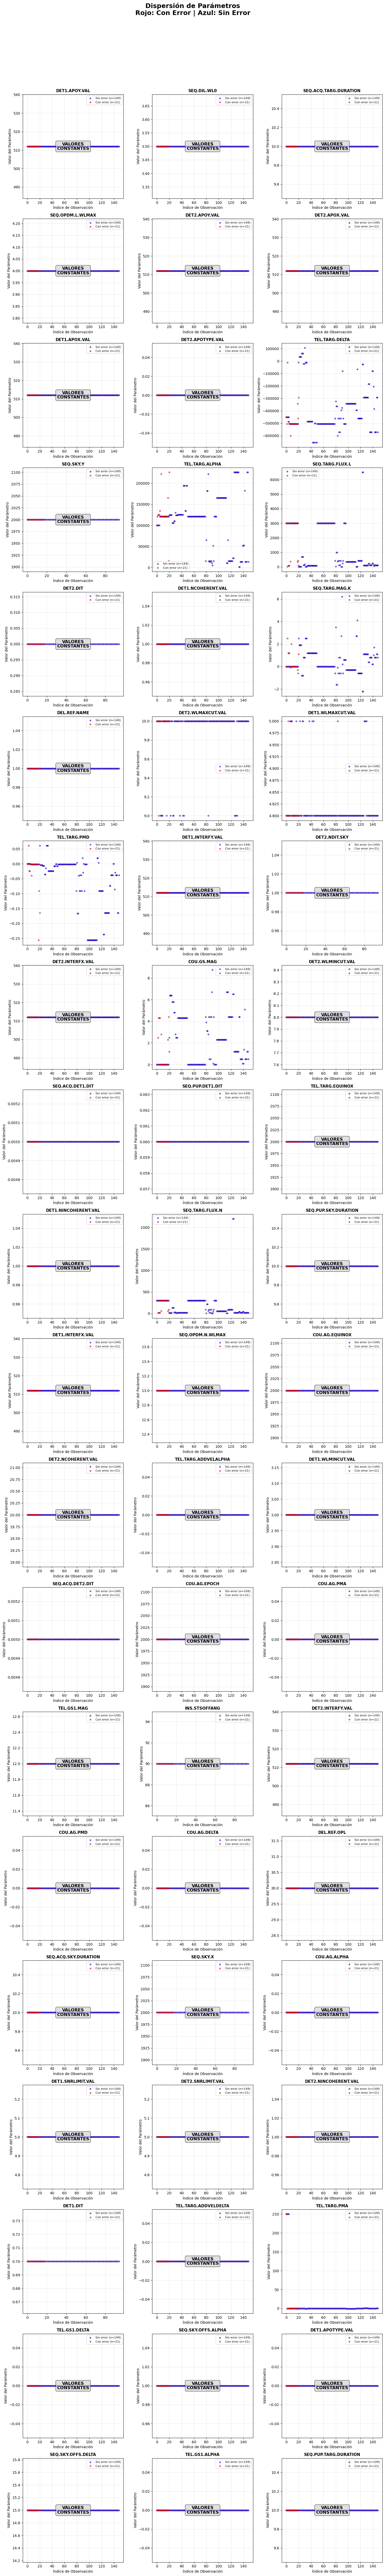

In [19]:
import os
import pandas as pd

dir_ok = "params_por_tpl"
dir_err = "params_por_tpl_Error"

for filename in os.listdir(dir_ok):
    if filename.endswith(".csv"):
        path_ok = os.path.join(dir_ok, filename)
        path_err = os.path.join(dir_err, filename)

        if os.path.exists(path_err):
            print(f"\nComparando {filename}")

            df_ok = pd.read_csv(path_ok, index_col=0)
            df_err = pd.read_csv(path_err, index_col=0)
            columns = list(set(df_ok.columns) & set(df_err.columns))
            df_ok = df_ok[columns]
            df_err = df_err[columns]
            graficos_dispersion_por_columna(df_ok, df_err)
        else:
            print(f"Archivo no encontrado en errores: {filename}")
